## Mục 1. Cài đặt môi trường


### 1.1. Cài đặt gói thư viện

In [1]:
# 1.1.1. Cài Tesseract OCR, tiếng Việt và tiện ích xử lý PDF
!apt-get install -y tesseract-ocr tesseract-ocr-vie poppler-utils
# 1.3.2. Cài thư viện Google Sheets và PyDrive
!pip install -q gspread gspread_dataframe PyDrive
# 1.1.3. Cài thư viện Python phục vụ OCR, PDF và xử lý văn bản
!pip install pytesseract pdf2image ipywidgets opencv-python regex underthesea openai python-docx

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
The following NEW packages will be installed:
  poppler-utils tesseract-ocr-vie
0 upgraded, 2 newly installed, 0 to remove and 35 not upgraded.
Need to get 603 kB of archives.
After this operation, 1,243 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.8 [186 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-vie all 1:4.00~git30-7274cfa-1.1 [417 kB]
Fetched 603 kB in 0s (4,268 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 126111 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.8_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.8) ...
Selecting previously unselected package tesseract-ocr-vie.
Preparing to unpack .../t

### 1.2. Kết nối Drive

In [2]:
# 1.2.1. Import thư viện để kết nối Google Drive
from google.colab import drive
from google.colab import auth
import google.auth, gspread
from oauth2client.client import GoogleCredentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

# 1.2.2. Mount Google Drive vào môi trường Colab
drive.mount('/content/drive')

Mounted at /content/drive


### 1.3. Thiết lập thư viện

In [31]:
# 1.3.1. Import thư viện hệ thống và xử lý văn bản
import os
import io
import re
import csv
import json
import time
import gc as garbage
import unicodedata
from pathlib import Path

import numpy as np
import pandas as pd
import regex

# 1.3.2. Import thư viện AI và xử lý NLP
from underthesea import text_normalize
import openai
from openai import OpenAI

# 1.3.3. Import thư viện xử lý ảnh và OCR
import cv2
from PIL import Image
from pdf2image import convert_from_bytes, pdfinfo_from_bytes
import pytesseract

# 1.3.4. Import thư viện hiển thị và giao diện
import ipywidgets as widgets
from IPython.display import display
from docx import Document

# 1.3.5. Xác thực với Google Colab, Drive và Sheets
from google.colab import auth
auth.authenticate_user()

import google.auth
import gspread
from oauth2client.client import GoogleCredentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

creds, _ = google.auth.default()
gc = gspread.authorize(creds)
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 1.3.6. Import thư viện xử lý Google Sheets dưới dạng DataFrame
import gspread_dataframe as gd
from gspread_dataframe import get_as_dataframe, set_with_dataframe

# 1.3.7. Import thư viện đa tiến trình (phục vụ OCR ảnh song song nếu có)
from multiprocessing import Pool, cpu_count
from concurrent.futures import ProcessPoolExecutor, as_completed

# 5.1, 5.2, 5.3. Thư viện vẽ biểu đồ, thống kê và phân tích
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

## Mục 2. Xử lý văn bản

### 2.1. Trích xuất PB lần 1

In [10]:
# 2.1.1. Làm sạch chuỗi tên phòng ban từ tên file
def clean_department(dept):
    # Thay các ký tự "chuyển" theo sau dấu gạch dưới thành "chuyển "
    dept = re.sub(r'^(chuyển)[\s_]+', r'\1 ', dept, flags=re.IGNORECASE)
    # Loại bỏ các ký tự thừa ở cuối chuỗi
    dept = re.sub(r'[,._\s]+$', '', dept)
    # Nếu dư dấu ")", loại bỏ đến khi cân bằng với "("
    while dept.endswith(")") and dept.count(")") > dept.count("("):
        dept = dept[:-1].rstrip()
    dept = re.sub(r'[,._\s]+$', '', dept)
    return dept

# 2.1.2. Trích xuất tên phòng ban từ chuỗi đã làm sạch
def extract_department_names(dept):
    # Nếu bắt đầu bằng các từ không phải tên đơn vị → loại
    if dept.lower().startswith(("thông tư", "quyết định", "điều lệ", "công văn", "thông báo")):
        return "Không có"
    # Tách theo dấu phẩy, loại bỏ ký tự cuối thừa
    tokens = [token.strip() for token in dept.split(',')]
    processed = [re.sub(r'[,._\s]+$', '', t) for t in tokens if t]
    return ", ".join(processed) if processed else "Không có"

# 2.1.3. Duyệt qua tất cả file .pdf/.docx và trích xuất tên đơn vị
folder_path    = "/content/drive/My Drive/DocAIx/data/vanban_goc"
files          = [f for f in os.listdir(folder_path) if f.lower().endswith(('.pdf', '.docx'))]
total_files    = len(files)
results        = []

for i, filename in enumerate(files, start=1):
    print("-" * 50)
    print(f"- File {i}/{total_files}: {filename}")

    base = os.path.splitext(filename)[0]
    base = re.sub(r'_\d+$', '', base)
    normalized = unicodedata.normalize('NFC', base)
    lower_base = normalized.lower()

    idx = lower_base.find("chuyển")
    if idx != -1:
        dept = normalized[idx:]
        dept = clean_department(dept)
    else:
        dept = "Không có"

    # In kết quả sơ bộ
    print(f"  • Nhận dạng nhanh:  {dept}")
    print(f"  • Sơ lượt lần 1:    {dept}")

    # Ghi lại nếu hợp lệ
    if not dept.lower().startswith(("thông tư", "quyết định", "điều lệ", "công văn", "thông báo")) and dept != "Không có":
        names = extract_department_names(dept)
        results.append((i, names))

print("-" * 50)

# 2.1.4. Ghi kết quả ra file TXT
output_file = "/content/drive/My Drive/DocAIx/data/data_repair_departments_v1.txt"
with open(output_file, "w", encoding="utf-8") as f:
    for pos, names in results:
        f.write(f"{pos}. Phòng ban: {names}\n")

# 2.1.5. In thống kê tổng kết ra màn hình
print(f"Đã cập nhật kết quả vào file: {output_file}")
print(f"Tổng file có phòng ban: {len(results)}/{total_files}")

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  • Sơ lượt lần 1:    Chuyển NNTS, Viện KHCNMT nắm thông tin
--------------------------------------------------
- File 7026/8274: Về việc chủ động ứng phó đợt xâm nhập mặn cao điểm trên địa bàn tỉnh (Số đến 733 ngày 18_02_2025 Chuyển NNTS, Viện KHCNMT nắm thông tin)_1.pdf
  • Nhận dạng nhanh:  Chuyển NNTS, Viện KHCNMT nắm thông tin
  • Sơ lượt lần 1:    Chuyển NNTS, Viện KHCNMT nắm thông tin
--------------------------------------------------
- File 7027/8274: Về việc triển khai thực hiện Thông tư của Bộ trưởng Bộ Tài nguyên và Môi trường (Số đến 732 ngày 18_02_2025 Chuyển QTTB, KHCN, KTCN (BMXD))_1.pdf
  • Nhận dạng nhanh:  Chuyển QTTB, KHCN, KTCN (BMXD)
  • Sơ lượt lần 1:    Chuyển QTTB, KHCN, KTCN (BMXD)
--------------------------------------------------
- File 7028/8274: Về việc triển khai thực hiện Thông tư của Bộ trưởng Bộ Tài nguyên v

### 2.2. Trích xuất PB vào Sheet 1

In [11]:
# 2.2.1. Đọc file TXT đã trích xuất để lấy danh sách tên phòng ban
txt_file = "/content/drive/My Drive/DocAIx/data/data_repair_departments_v1.txt"
with open(txt_file, "r", encoding="utf-8") as f:
    lines = f.readlines()

departments = []
pattern = r'^\d+\.\s*Phòng ban:\s*(.+)$'
for line in lines:
    line = line.strip()
    if line:
        match = re.match(pattern, line)
        if match:
            dept = match.group(1).strip()
            departments.append(dept)

# 2.2.2. Chuẩn hoá danh sách: loại trùng và sắp xếp theo ABC
unique_departments = sorted(list(set(departments)), key=lambda s: s.lower())

# 2.2.3. Tạo DataFrame mới với cột departments_v1 và cột sửa tay rỗng
new_df = pd.DataFrame({'departments_v1': unique_departments})
new_df['departments_v2'] = ""  # Cột này sẽ sửa tay trên Google Sheet

# 2.2.4. Kiểm tra và mở Google Sheet "data_repair_departments_v1" trong thư mục DocAIx/data
docaix_folder_list = drive.ListFile({
    'q': "mimeType='application/vnd.google-apps.folder' and title='DocAIx' and 'root' in parents and trashed=false"
}).GetList()

if docaix_folder_list:
    docaix_folder = docaix_folder_list[0]
    data_folder_list = drive.ListFile({
        'q': f"mimeType='application/vnd.google-apps.folder' and title='data' and '{docaix_folder['id']}' in parents and trashed=false"
    }).GetList()
    if data_folder_list:
        data_folder_id = data_folder_list[0]['id']
    else:
        data_folder_id = None
else:
    data_folder_id = None

sheet_title = "data_repair_departments_v1"
sheet = None

if data_folder_id:
    file_query = f"mimeType='application/vnd.google-apps.spreadsheet' and title='{sheet_title}' and '{data_folder_id}' in parents and trashed=false"
    sheet_list = drive.ListFile({'q': file_query}).GetList()
    if sheet_list:
        sheet_file = sheet_list[0]
        sheet_id = sheet_file['id']
        sheet = gc.open_by_key(sheet_id)
    else:
        sheet = gc.create(sheet_title)
        sheet_id = sheet.id
        file_to_move = drive.CreateFile({'id': sheet_id})
        file_to_move.FetchMetadata("parents")
        previous_parents = ",".join([p['id'] for p in file_to_move['parents']])
        file_to_move.Upload({'addParents': data_folder_id, 'removeParents': previous_parents})
else:
    sheet = gc.create(sheet_title)
    sheet_id = sheet.id

# 2.2.5. Đọc dữ liệu cũ từ sheet để giữ lại cột departments_v2 đã chỉnh
from gspread_dataframe import get_as_dataframe, set_with_dataframe
worksheet = sheet.sheet1

try:
    old_df = get_as_dataframe(worksheet, evaluate_formulas=True, header=0)
    old_df = old_df.dropna(subset=["departments_v1"])
    old_df["departments_v1"] = old_df["departments_v1"].astype(str)
    old_df["departments_v2"] = old_df["departments_v2"].astype(str)
except Exception:
    old_df = pd.DataFrame(columns=["departments_v1", "departments_v2"])

# 2.2.6. Tạo dict lưu lại bản mapping cũ để merge vào dữ liệu mới
old_dict = {}
for _, row in old_df.iterrows():
    dept = row["departments_v1"].strip()
    old_dict[dept] = row["departments_v2"]

# 2.2.7. Hợp nhất dữ liệu mới với dữ liệu cũ (union phòng ban)
union_departments = list(set(unique_departments) | set(old_dict.keys()))
merged_df = pd.DataFrame({'departments_v1': union_departments})
merged_df['departments_v2'] = merged_df['departments_v1'].apply(lambda x: old_dict.get(x, ""))

# 2.2.8. Sắp xếp theo cột departments_v2 với 3 mức độ ưu tiên
def sort_order(value):
    value = str(value).strip()
    if value != "" and value != "Không có":
        return (0, value.lower())
    elif value == "Không có":
        return (1, value.lower())
    else:
        return (2, value.lower())

merged_df['sort_key'] = merged_df['departments_v2'].apply(sort_order)
merged_df = merged_df.sort_values(by='sort_key').drop(columns=['sort_key']).reset_index(drop=True)

# 2.2.9. Ghi DataFrame hợp nhất lên Google Sheet (không làm mất dữ liệu cũ)
worksheet.clear()
set_with_dataframe(worksheet, merged_df)

# 2.2.10. In xác nhận cập nhật Google Sheet
print(f"Google Sheet '{sheet_title}' đã được cập nhật (ID: {sheet.id}).")

Google Sheet 'data_repair_departments_v1' đã được cập nhật (ID: 11fFFV-30PEBuVks8sGzZ23VznYBduN3gYnUIs1TfqM0).


### 2.3. Trích xuất PB lần 2

In [12]:
# 2.3.1. Hàm làm sạch chuỗi tên phòng ban
def clean_department(dept):
    dept = re.sub(r'^(chuyển)[\s_]+', r'\1 ', dept, flags=re.IGNORECASE)
    dept = re.sub(r'[,._\s]+$', '', dept)
    while dept.endswith(")") and dept.count(")") > dept.count("("):
        dept = dept[:-1].rstrip()
    return re.sub(r'[,._\s]+$', '', dept)

# 2.3.2. Hàm trích xuất tên phòng ban (bỏ các loại văn bản hành chính)
def extract_department_names(dept):
    if dept.lower().startswith(("thông tư", "quyết định", "điều lệ", "công văn", "thông báo")):
        return "Không có"
    tokens = [t.strip() for t in dept.split(',')]
    processed = [re.sub(r'[,._\s]+$', '', t) for t in tokens if t]
    return ", ".join(processed) if processed else "Không có"

# 2.3.3. Đọc dữ liệu từ Google Sheet v1 và tạo dict mapping phòng ban
sheet_title = "data_repair_departments_v1"
ws = gc.open(sheet_title).sheet1

try:
    old_df = get_as_dataframe(ws, evaluate_formulas=True, header=0)
    old_df = old_df.dropna(subset=["departments_v1"])
    old_df["departments_v1"] = old_df["departments_v1"].astype(str).str.strip()
    old_df["departments_v2"] = old_df["departments_v2"].astype(str).str.strip()
except:
    old_df = pd.DataFrame(columns=["departments_v1", "departments_v2"])

mapping_dict = dict(zip(old_df["departments_v1"], old_df["departments_v2"]))

# 2.3.4. Duyệt lại toàn bộ file văn bản và áp dụng mapping
folder_path = "/content/drive/My Drive/DocAIx/data/vanban_goc"
files       = [f for f in os.listdir(folder_path) if f.lower().endswith(('.pdf', '.docx'))]
total       = len(files)
results     = []

for i, fn in enumerate(files, start=1):
    print("-" * 50)
    print(f"- File {i}/{total} – {fn}")

    base = os.path.splitext(fn)[0]
    base = re.sub(r'_\d+$', '', base)
    norm = unicodedata.normalize('NFC', base)
    low  = norm.lower()

    idx = low.find("chuyển")
    if idx != -1:
        dept = clean_department(norm[idx:])
    else:
        dept = "Không có"

    if dept.lower().startswith(("thông tư", "quyết định", "điều lệ", "công văn", "thông báo")):
        extracted = "Không có"
    else:
        extracted = extract_department_names(dept)

    # Ưu tiên dùng mapping nếu có, ngược lại dùng kết quả vừa trích xuất
    final = mapping_dict.get(extracted, "") or extracted

    print(f"  • Nhận dạng nhanh:  {dept}")
    print(f"  • Sơ lượt lần 1:    {extracted}")
    print(f"  • Sơ lượt lần 2:    {final}")

    if final != "Không có":
        results.append((i, final))

print("-" * 50)

# 2.3.5. Ghi kết quả lần 2 vào file TXT
out = "/content/drive/My Drive/DocAIx/data/data_repair_departments_v2.txt"
with open(out, "w", encoding="utf-8") as f:
    for pos, dep in sorted(results, key=lambda x: x[0]):
        f.write(f"{pos}. Phòng ban: {dep}\n")

# 2.3.6. In thông báo hoàn tất và thống kê tổng hợp
print(f"Đã cập nhật file: {out} – Tổng {len(results)}/{total}")

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  • Nhận dạng nhanh:  Chuyển BGH, VPHĐT, VPĐU, ĐTN, CĐCS, TrT, HCTH, CTSVHS, các đơn vị thuộc và trực thuộc
  • Sơ lượt lần 1:    Chuyển BGH, VPHĐT, VPĐU, ĐTN, CĐCS, TrT, HCTH, CTSVHS, các đơn vị thuộc và trực thuộc
  • Sơ lượt lần 2:    Chuyển BGH; VPHĐT; VPĐU; ĐTN; CĐCS; TrT; HCTH; CTSVHS; Các đơn vị thuộc và trực thuộc
--------------------------------------------------
- File 7276/8274 – Về việc gửi Thể lệ và hưởng ứng Cuộc thi _Em yêu biển, đảo quê hương_ giai đoạn 2024-2030 và những năm tiếp theo (Số đến 277 ngày 16_01_2025 Chuyển CĐCS, ĐTN, CTSVHS, THSP)_2.pdf
  • Nhận dạng nhanh:  Chuyển CĐCS, ĐTN, CTSVHS, THSP
  • Sơ lượt lần 1:    Chuyển CĐCS, ĐTN, CTSVHS, THSP
  • Sơ lượt lần 2:    Chuyển CĐCS; ĐTN; CTSVHS; THSP
--------------------------------------------------
- File 7277/8274 – Về việc gửi Thể lệ và hưởng ứng Cuộc thi _Em yêu biển, đảo quê hương_ giai đo

### 2.4. Trích xuất PB vào Sheet 2

In [13]:
# 2.4.1. Đọc file TXT đã xử lý lần 2 để lấy danh sách departments_v2
txt_file = "/content/drive/My Drive/DocAIx/data/data_repair_departments_v2.txt"
with open(txt_file, "r", encoding="utf-8") as f:
    lines = f.readlines()

depts_v2 = []
pattern = r'^\d+\.\s*Phòng ban:\s*(.+)$'
for line in lines:
    line = line.strip()
    if not line:
        continue
    m = re.match(pattern, line)
    if m:
        depts_v2.append(m.group(1).strip())

# 2.4.2. Loại trùng và sắp xếp danh sách theo chữ cái
unique_v2 = sorted(set(depts_v2), key=lambda s: s.lower())

# 2.4.3. Tạo DataFrame mới với cột departments_v2 và để trống departments_v3
new_df = pd.DataFrame({
    'departments_v2': unique_v2,
    'departments_v3': ["" for _ in unique_v2]
})

# 2.4.4. Xác thực Google Drive (nếu chưa thực hiện ở phần trước)
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2.4.5. Tìm hoặc tạo Google Sheet "data_repair_departments_v2" trong thư mục DocAIx/data
docaix = drive.ListFile({
    'q': "mimeType='application/vnd.google-apps.folder' and title='DocAIx' and 'root' in parents and trashed=false"
}).GetList()

data_folder_id = None
if docaix:
    dfolders = drive.ListFile({
        'q': f"mimeType='application/vnd.google-apps.folder' and title='data' and '{docaix[0]['id']}' in parents and trashed=false"
    }).GetList()
    if dfolders:
        data_folder_id = dfolders[0]['id']

sheet_title = "data_repair_departments_v2"
if data_folder_id:
    q = f"mimeType='application/vnd.google-apps.spreadsheet' and title='{sheet_title}' and '{data_folder_id}' in parents and trashed=false"
    flist = drive.ListFile({'q': q}).GetList()
    if flist:
        sh = gc.open_by_key(flist[0]['id'])
    else:
        sh = gc.create(sheet_title)
        f = drive.CreateFile({'id': sh.id})
        f.FetchMetadata("parents")
        prev = ",".join([p['id'] for p in f['parents']])
        f.Upload({'addParents': data_folder_id, 'removeParents': prev})
else:
    sh = gc.create(sheet_title)

# 2.4.6. Đọc dữ liệu cũ (nếu có) để giữ lại cột departments_v3 đã nhập tay
from gspread_dataframe import get_as_dataframe, set_with_dataframe
ws = sh.sheet1

try:
    old_df = get_as_dataframe(ws, evaluate_formulas=True, header=0)
    old_df = old_df.dropna(subset=["departments_v2"])
    old_df["departments_v2"] = old_df["departments_v2"].astype(str).str.strip()
    old_df["departments_v3"] = old_df["departments_v3"].astype(str).str.strip()
except Exception:
    old_df = pd.DataFrame(columns=["departments_v2", "departments_v3"])

old_map = dict(zip(old_df["departments_v2"], old_df["departments_v3"]))

# 2.4.7. Hợp nhất dữ liệu mới với dữ liệu cũ, và sắp xếp theo độ ưu tiên của departments_v3
union_v2 = sorted(set(unique_v2) | set(old_map.keys()), key=lambda s: s.lower())
merged_df = pd.DataFrame({'departments_v2': union_v2})
merged_df['departments_v3'] = merged_df['departments_v2'].map(old_map).fillna("")

def sort_key(val):
    v = val.strip()
    if v and v != "Không có":
        return (0, v.lower())
    elif v == "Không có":
        return (1, v.lower())
    else:
        return (2, "")

merged_df['__sort'] = merged_df['departments_v3'].apply(sort_key)
merged_df = merged_df.sort_values(by='__sort').drop(columns='__sort').reset_index(drop=True)

# 2.4.8. Ghi dữ liệu mới lên Google Sheet, giữ nguyên phần đã sửa tay
ws.clear()
set_with_dataframe(ws, merged_df)

# 2.4.9. In thông báo xác nhận
print(f"Google Sheet '{sheet_title}' đã được cập nhật (ID: {sh.id}).")

Google Sheet 'data_repair_departments_v2' đã được cập nhật (ID: 1kuwDBNORqgCocxtW1LpLb7NCyr4cvJmPu6WmATBVuU4).


### 2.5. Trích xuất PB lần 3

In [14]:
# 2.5.1. Hàm làm sạch tên phòng ban từ tên file
def clean_department(dept):
    dept = re.sub(r'^(chuyển)[\s_]+', r'\1 ', dept, flags=re.IGNORECASE)
    dept = re.sub(r'[,._\s]+$', '', dept)
    while dept.endswith(")") and dept.count(")") > dept.count("("):
        dept = dept[:-1].rstrip()
    dept = re.sub(r'[,._\s]+$', '', dept)
    return dept

# 2.5.2. Hàm tách tên phòng ban từ chuỗi đã làm sạch
def extract_department_names(dept):
    if dept.lower().startswith(("thông tư","quyết định","điều lệ","công văn","thông báo")):
        return "Không có"
    tokens = [t.strip() for t in dept.split(',')]
    processed = [re.sub(r'[,._\s]+$', '', t) for t in tokens if t]
    return ", ".join(processed) if processed else "Không có"

# 2.5.3. Hàm mở hoặc tạo Google Sheet trong thư mục DocAIx/data
def open_sheet_in_folder(title):
    docaix = drive.ListFile({
        'q': "mimeType='application/vnd.google-apps.folder' and title='DocAIx' "
             "and 'root' in parents and trashed=false"
    }).GetList()
    data_id = None
    if docaix:
        data_folder = drive.ListFile({
            'q': f"mimeType='application/vnd.google-apps.folder' and title='data' "
                  f"and '{docaix[0]['id']}' in parents and trashed=false"
        }).GetList()
        if data_folder:
            data_id = data_folder[0]['id']

    if data_id:
        q = (f"mimeType='application/vnd.google-apps.spreadsheet' and title='{title}' "
             f"and '{data_id}' in parents and trashed=false")
        lst = drive.ListFile({'q': q}).GetList()
        if lst:
            return gc.open_by_key(lst[0]['id'])
        sh = gc.create(title)
        f = drive.CreateFile({'id': sh.id})
        f.FetchMetadata("parents")
        prev = ",".join([p['id'] for p in f['parents']])
        f.Upload({'addParents': data_id, 'removeParents': prev})
        return sh
    return gc.create(title)

# 2.5.4. Đọc dữ liệu từ sheet v1 (departments_v1 → departments_v2)
df1 = gd.get_as_dataframe(
    open_sheet_in_folder("data_repair_departments_v1").sheet1,
    evaluate_formulas=True, header=0
).dropna(subset=["departments_v1"])
df1["departments_v1"] = df1["departments_v1"].astype(str).str.strip()
df1["departments_v2"] = df1["departments_v2"].astype(str).str.strip()
map12 = {k: v for k, v in zip(df1["departments_v1"], df1["departments_v2"]) if v}

# 2.5.5. Đọc dữ liệu từ sheet v2 (departments_v2 → departments_v3)
df2 = gd.get_as_dataframe(
    open_sheet_in_folder("data_repair_departments_v2").sheet1,
    evaluate_formulas=True, header=0
).dropna(subset=["departments_v2"])
df2["departments_v2"] = df2["departments_v2"].astype(str).str.strip()
df2["departments_v3"] = df2["departments_v3"].astype(str).str.strip()
map23 = {k: v for k, v in zip(df2["departments_v2"], df2["departments_v3"]) if v}

# 2.5.6. Duyệt toàn bộ file gốc và áp dụng chuỗi mapping v1 → v2 → v3
folder = "/content/drive/My Drive/DocAIx/data/vanban_goc"
files  = [f for f in os.listdir(folder) if f.lower().endswith(('.pdf','.docx'))]
total  = len(files)
results = []

cnt_no_1 = cnt_no_2 = cnt_no_3 = 0  # Đếm số lần "Không có" ở mỗi lượt

for idx, fn in enumerate(files, 1):
    base = re.sub(r'_\d+$', '', os.path.splitext(fn)[0])
    norm = unicodedata.normalize('NFC', base)
    i_chuyen = norm.lower().find("chuyển")

    dept_raw = clean_department(norm[i_chuyen:]) if i_chuyen != -1 else "Không có"

    extracted = (extract_department_names(dept_raw)
                 if not dept_raw.lower().startswith(("thông tư","quyết định","điều lệ",
                                                     "công văn","thông báo"))
                 else "Không có")

    step1 = map12.get(extracted, "").strip() or extracted
    step2 = map23.get(step1,   "").strip() or step1
    final = step2

    if extracted == "Không có": cnt_no_1 += 1
    if step1    == "Không có": cnt_no_2 += 1
    if final    == "Không có": cnt_no_3 += 1

    print(f"- File {idx}/{total}: {fn}")
    print(f"  • Nhận dạng:       {dept_raw}")
    print(f"  • Sơ lượt lần 1:   {extracted}")
    print(f"  • Sơ lượt lần 2:   {step1}")
    print(f"  • Sơ lượt lần 3:   {final}")
    print("-"*50)

    if final != "Không có":
        results.append((idx, final))

# 2.5.7. Ghi kết quả sau 3 lượt mapping vào file TXT
results.sort(key=lambda x: x[0])
out_path = "/content/drive/My Drive/DocAIx/data/data_repair_departments_v3.txt"
with open(out_path, "w", encoding="utf-8") as f:
    for pos, dep in results:
        f.write(f"{pos}. Phòng ban: {dep}\n")

# 2.5.8. In thống kê tổng hợp cho cả 3 lượt trích xuất
good1 = total - cnt_no_1
good2 = total - cnt_no_2
good3 = total - cnt_no_3

summary_lines = [
    f"Tổng file quét: {total}",
    f"Sơ lượt lần 1:  Có phòng ban = {good1:>4}  |  Không có = {cnt_no_1}",
    f"Sơ lượt lần 2:  Có phòng ban = {good2:>4}  |  Không có = {cnt_no_2}",
    f"Sơ lượt lần 3:  Có phòng ban = {good3:>4}  |  Không có = {cnt_no_3}",
]

width = max(len(line) for line in summary_lines)

print("\n" + " TỔNG KẾT ".center(width, "="))
for line in summary_lines:
    print(line)

print(f"\n==> Đã ghi file kết quả: {out_path}")

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
- File 7443/8274: V_v thực hiện Thông tư số 88_2024_TT-BTC ngày 24_12_2024 của Bộ trưởng Bộ Tài chính (Số đến_ 5967, ngày 31_12_2024, chuyển_ BGH, Phòng TC, QTTB, TTrPC)_2.pdf
  • Nhận dạng:       chuyển BGH, Phòng TC, QTTB, TTrPC
  • Sơ lượt lần 1:   chuyển BGH, Phòng TC, QTTB, TTrPC
  • Sơ lượt lần 2:   Chuyển BGH; Phòng TC; QTTB; TTrPC
  • Sơ lượt lần 3:   Chuyển BGH; Phòng TC; QTTB; TTrPC
--------------------------------------------------
- File 7444/8274: Về việc tăng cường đảm bảo an toàn thông tin mạng trong dịp Tết Dương lịch 2025, Tết Nguyên đán Ất Tỵ và Lễ kỷ niệm 95 n ...Số đến_ 5964, ngày 31_12_2024, chuyển_ Phòng CNTT, RDI, KTCN)_1.pdf
  • Nhận dạng:       chuyển Phòng CNTT, RDI, KTCN
  • Sơ lượt lần 1:   chuyển Phòng CNTT, RDI, KTCN
  • Sơ lượt lần 2:   Chuyển Phòng CNTT; RDI; KTCN
  • Sơ lượt lần 3:   Chuyển Phòng CNTT; RDI; KTCN
-------------------

### 2.6. Trích xuất PB vào Sheet 3

In [15]:
# 2.6.1. Đọc file TXT kết quả lần 3 và tách các phòng ban theo dấu chấm phẩy (;)
txt_path = "/content/drive/My Drive/DocAIx/data/data_repair_departments_v3.txt"
pattern = r'^\d+\.\s*Phòng ban:\s*(.+)$'

tokens = []
with open(txt_path, "r", encoding="utf-8") as f:
    for line in f:
        m = re.match(pattern, line.strip())
        if not m:
            continue
        for t in m.group(1).split(";"):
            token = t.strip()
            if token:
                tokens.append(token)

unique_v4 = sorted(set(tokens), key=lambda s: s.lower())

# 2.6.2. Tạo DataFrame mới với cột departments_v4 và cột mô tả để trống
new_df = pd.DataFrame({
    "departments_v4": unique_v4,
    "describe": [""] * len(unique_v4)
})

# 2.6.3. Tìm hoặc tạo Google Sheet "data_repair_departments_v3" trong thư mục DocAIx/data
def open_sheet_in_folder(title):
    docaix = drive.ListFile({
        'q': "mimeType='application/vnd.google-apps.folder' and "
             "title='DocAIx' and 'root' in parents and trashed=false"
    }).GetList()
    data_id = None
    if docaix:
        data_folders = drive.ListFile({
            'q': f"mimeType='application/vnd.google-apps.folder' and title='data' "
                  f"and '{docaix[0]['id']}' in parents and trashed=false"
        }).GetList()
        if data_folders:
            data_id = data_folders[0]['id']

    if data_id:
        q = f"mimeType='application/vnd.google-apps.spreadsheet' and title='{title}' " \
            f"and '{data_id}' in parents and trashed=false"
        fnd = drive.ListFile({'q': q}).GetList()
        if fnd:
            return gc.open_by_key(fnd[0]['id'])
        sh = gc.create(title)
        file_ = drive.CreateFile({'id': sh.id})
        file_.FetchMetadata("parents")
        prev = ",".join([p['id'] for p in file_['parents']])
        file_.Upload({'addParents': data_id, 'removeParents': prev})
        return sh
    return gc.create(title)

sheet_title = "data_repair_departments_v3"
sheet = open_sheet_in_folder(sheet_title)
ws = sheet.sheet1

# 2.6.4. Đọc dữ liệu cũ nếu có để giữ lại phần mô tả đã điền tay
try:
    old_df = gd.get_as_dataframe(ws, evaluate_formulas=True, header=0)
    old_df = old_df.dropna(subset=["departments_v4"])
    old_df["departments_v4"] = old_df["departments_v4"].astype(str).str.strip()
    old_df["describe"]       = old_df["describe"].astype(str).str.strip()
except Exception:
    old_df = pd.DataFrame(columns=["departments_v4", "describe"])

old_map = dict(zip(old_df["departments_v4"], old_df["describe"]))

# 2.6.5. Gộp danh sách mới với dữ liệu cũ theo union & tạo DataFrame hợp nhất
all_v4 = sorted(set(unique_v4) | set(old_map.keys()), key=lambda s: s.lower())
merged = pd.DataFrame({
    "departments_v4": all_v4,
    "describe": [old_map.get(k, "") for k in all_v4]
})

# 2.6.6. Sắp xếp dữ liệu: ưu tiên những describe đã có (hợp lệ), rồi đến trống
def sort_key(row):
    desc = str(row["describe"]).strip()
    if desc and desc.lower() != "nan":
        return (0, desc.lower())    # describe hợp lệ, sắp xếp a-z
    elif desc.lower() == "nan":
        return (1, "")              # describe là "nan"
    else:
        return (2, "")              # describe rỗng

merged = merged.sort_values(by=["describe"], key=lambda col: col.fillna("").astype(str).str.strip())
merged = merged.assign(__sort_key=merged.apply(sort_key, axis=1))
merged = merged.sort_values("__sort_key").drop(columns="__sort_key").reset_index(drop=True)

# 2.6.7. Ghi DataFrame hợp nhất lên Google Sheet
ws.clear()
gd.set_with_dataframe(ws, merged)

# 2.6.8. In thống báo xác nhận và tổng số phòng ban đã xử lý
print(f"Google Sheet '{sheet_title}' đã được tạo/cập nhật (ID: {sheet.id}).")
print(f"Tổng phòng ban (v4): {len(merged)}")

Google Sheet 'data_repair_departments_v3' đã được tạo/cập nhật (ID: 1PDsz2sVNp7CnnOcsCvSTup7ljI9fU_LtCM2C5HQf9QI).
Tổng phòng ban (v4): 1056


# Mục 3. Trích xuất văn bản vào Dataset

## 3.0. Thiết lập tên các loại VB

In [4]:
# 3.0.1. Danh sách loại văn bản hành chính (dùng chung cho toàn bộ pipeline)
document_types = """
1. NGHỊ QUYẾT (viết tắt: NQ)
2. QUYẾT ĐỊNH (viết tắt: QĐ)
3. CHỈ THỊ (viết tắt: CT)
4. QUY CHẾ (viết tắt: QC)
5. QUY ĐỊNH (viết tắt: QYĐ)
6. THÔNG CÁO (viết tắt: TC)
7. THÔNG BÁO (viết tắt: TB)
8. HƯỚNG DẪN (viết tắt: HD)
9. CHƯƠNG TRÌNH (viết tắt: CTr)
10. KẾ HOẠCH (viết tắt: KH)
11. PHƯƠNG ÁN (viết tắt: PA)
12. ĐỀ ÁN (viết tắt: ĐA)
13. DỰ ÁN (viết tắt: DA)
14. BÁO CÁO (viết tắt: BC)
15. BIÊN BẢN (viết tắt: BB)
16. TỜ TRÌNH (viết tắt: TTr)
17. HỢP ĐỒNG (viết tắt: HĐ)
18. CÔNG VĂN (Dấu hiệu nhận biết là có từ: Kính gửi)
19. CÔNG ĐIỆN (viết tắt: CĐ)
20. BẢN GHI NHỚ (viết tắt: BGN)
21. BẢN THỎA THUẬN (viết tắt: BTT)
22. GIẤY ỦY QUYỀN (viết tắt: GUQ)
23. GIẤY MỜI (viết tắt: GM)
24. GIẤY GIỚI THIỆU (viết tắt: GGT)
25. GIẤY NGHỈ PHÉP (viết tắt: GNP)
26. PHIẾU GỬI (viết tắt: PG)
27. PHIẾU CHUYỂN (viết tắt: PC)
28. PHIẾU BÁO (viết tắt: PB)
29. THƯ CÔNG
"""

## 3.1. Thiết lập staff Gemma 1

In [33]:
def summarize_with_openrouter_gemma_v1(ocr_text, document_types):
    prompt = f"""
Bạn là một trợ lý AI hành chính chuyên xử lý **văn bản OCR tiếng Việt**, kể cả khi có lỗi chính tả, nhiễu định dạng hoặc thiếu dấu.

🎯 Nhiệm vụ: Trích xuất chính xác **3 trường thông tin** sau:

---

🔹 1. `doc_type`: Loại văn bản
- Tìm dòng **IN HOA toàn bộ**, nằm **ngay sau dòng “Độc lập - Tự do - Hạnh phúc”**
- Nếu dòng đó trùng khớp với **một trong các loại văn bản hành chính** (danh sách phía dưới) → dùng làm `doc_type`
- Không chọn dòng chứa cụm: “Ban hành kèm theo Quyết định…”
- Nếu không xác định được → mặc định là `"CÔNG VĂN"`

---

🔹 2. `doc_issuer`: Cơ quan/đơn vị ban hành
- Lấy từ các dòng đầu văn bản, nằm **trước loại văn bản hoặc trước “Kính gửi”**
- Bỏ qua các dòng:
  - “CỘNG HÒA XÃ HỘI CHỦ NGHĨA VIỆT NAM”
  - “Độc lập - Tự do - Hạnh phúc”
- Ưu tiên dòng chứa từ khóa như: “UBND”, “BỘ”, “SỞ”, “PHÒNG”, “BAN”, “TRUNG TÂM”, “CỤC”
- Nếu có dạng “UBND TỈNH A – SỞ B” → chỉ giữ “Sở B” hoặc “B”

---

🔹 3. `doc_title`: Tiêu đề văn bản
- Thường nằm sau loại văn bản
- Giữ nguyên câu gốc (Bắt buộc sửa lỗi chính tả, viết lại cho đúng câu)

---

📌 Kết quả đầu ra:
Gồm đúng **3 dòng** theo định dạng:

1. doc_type    : ...
2. doc_issuer  : ...
3. doc_title   : ...

⛔ Không được thêm markdown, mô tả phụ hoặc dòng trống.

---

📘 Danh sách loại văn bản hành chính hợp lệ:
{document_types}

---

📄 Văn bản sau OCR:
{ocr_text}

==> Kết quả:
""".strip()

    response = client.chat.completions.create(
        model=GEMMA_MODEL_ID,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.0,
        extra_headers=EXTRA_HEADERS
    )

    return response.choices[0].message.content.strip()

## 3.2. Thiết lập staff Gemma 2

In [5]:
def summarize_with_openrouter_gemma_v2(ocr_text, document_types):
    prompt = f"""
Bạn là trợ lý AI chuyên trích xuất văn bản hành chính tiếng Việt từ kết quả OCR, kể cả khi có lỗi chính tả, thiếu dấu hoặc nhiễu định dạng.

🎯 Nhiệm vụ: Tóm tắt nội dung thành 3 trường cấu trúc sau, với quy tắc rõ ràng:

---

1. doc_type: Loại văn bản (QUYẾT ĐỊNH, CÔNG VĂN, THÔNG TƯ, THÔNG BÁO, THÔNG CÁO…)
- Ưu tiên dòng IN HOA nằm ngay sau “Độc lập - Tự do - Hạnh phúc”
- Nếu dòng này trùng một trong các loại trong danh sách chuẩn → chọn làm `doc_type`
- Không dùng dòng “Ban hành kèm theo Quyết định…” để suy ra loại văn bản
- Nếu không rõ → gán mặc định là “CÔNG VĂN”

2. doc_issuer: Cơ quan/đơn vị ban hành
- Xét đoạn đầu văn bản, bỏ qua dòng “CỘNG HÒA…” và “Độc lập…”
- Nếu có cụm kiểu: “UBND TỈNH A – SỞ B” → chỉ lấy phần sau cùng (“Sở B”)
- Ưu tiên dòng có các từ: “UBND”, “BỘ”, “SỞ”, “PHÒNG”, “TRUNG TÂM”, “CỤC”, v.v.
- Nếu nhiều dòng hợp lệ → chọn dòng gần tiêu đề nhất

3. doc_title: Tiêu đề văn bản
- Thường nằm sau loại văn bản
- Giữ nguyên câu gốc (Bắt buộc sửa lỗi chính tả, viết lại cho đúng câu)

---

📌 Định dạng đầu ra:

1. doc_type    : ...
2. doc_issuer  : ...
3. doc_title   : ...

⛔ Tuyệt đối không thêm mô tả phụ, chú thích, markdown hoặc dòng trống.

---

📘 Danh sách loại văn bản chuẩn:
{document_types}

---

📄 Văn bản OCR:
{ocr_text}

==> Kết quả:
""".strip()

    response = client.chat.completions.create(
        model=GEMMA_MODEL_ID,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.0,
        extra_headers=EXTRA_HEADERS
    )

    return response.choices[0].message.content.strip()

## 3.3. Thiết lập staff Gemma 3

In [6]:
def final_summary(ocr_text, summary1, summary2, document_types):
    prompt = f"""
Bạn là một trợ lý AI hành chính cấp cao. Bạn nhận được **2 bản tóm tắt sơ bộ** từ 2 trợ lý khác nhau, mỗi bản gồm:

1. doc_type    – Loại văn bản (Viết tên đầy đủ, không viết tắt)
2. doc_issuer  – Đơn vị ban hành
3. doc_title   – Tiêu đề văn bản

---

🎯 Nhiệm vụ:
Tạo ra **bản tóm tắt cuối cùng** gồm 3 dòng duy nhất, bằng cách:
- Chọn bản tốt hơn, hoặc
- Kết hợp các trường chính xác nhất từ cả hai.

---

📌 QUY TẮC chọn từng trường:

🔹 `doc_type`:
- Tìm dòng **IN HOA toàn bộ**, nằm ngay **sau “Độc lập - Tự do - Hạnh phúc”**
- Nếu dòng này trùng khớp một loại trong danh sách 29 văn bản hành chính → chọn làm `doc_type`
- Không chọn dòng có “Ban hành kèm theo Quyết định…”
- Nếu không chắc chắn → dùng “CÔNG VĂN” làm mặc định

🔹 `doc_issuer`:
- Tìm dòng chứa tên **đơn vị ban hành**, xuất hiện trước hoặc sau cụm “Độc lập - Tự do - Hạnh phúc”
- Ưu tiên dòng có từ khóa như: “SỞ”, “PHÒNG”, “TRƯỜNG”, “BỘ”, “BAN”, “UBND”, “CỤC”, “TRUNG TÂM”
- Nếu dạng “UBND tỉnh – Sở …” hoặc nhiều tổ chức → chỉ lấy phần ban hành chính
- Nếu xuất hiện `"TRƯỜNG"` gần với tiêu đề văn bản hơn các dòng khác → chọn dòng đó
- Được phép sửa lỗi OCR nếu rõ ràng

🔹 `doc_title`:
- Thường nằm sau loại văn bản
- Giữ nguyên câu gốc (Bắt buộc sửa lỗi chính tả, viết lại cho đúng câu)

---

📌 Đầu ra phải **chỉ gồm đúng 3 dòng**, theo định dạng sau:

1. doc_type    : ...
2. doc_issuer  : ...
3. doc_title   : ...

⛔ Không được viết thêm chú thích, mô tả, markdown hoặc dòng trống.

---

📘 Danh sách loại văn bản hành chính chuẩn:
{document_types}

---

📄 Văn bản gốc (OCR):
{ocr_text}

📑 Tóm tắt từ trợ lý 1:
{summary1}

📑 Tóm tắt từ trợ lý 2:
{summary2}

==> Bản tóm tắt cuối cùng:
""".strip()

    response = client.chat.completions.create(
        model=GEMMA_MODEL_ID,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.0,
        extra_headers=EXTRA_HEADERS
    )

    return response.choices[0].message.content.strip()

## 3.4. Thiết lập hàm OCR

In [7]:
# 3.4.1. Thiết lập đường dẫn lưu file
upload_folder = "/content/drive/MyDrive/DocAIx/data/vanban_goc"
os.makedirs(upload_folder, exist_ok=True)

# 3.4.2. Lưu file gốc
def save_file(filename, file_bytes):
    base, ext = os.path.splitext(filename)
    dest = os.path.join(upload_folder, filename)
    counter = 1
    while os.path.exists(dest):
        dest = os.path.join(upload_folder, f"{base}_{counter}{ext}")
        counter += 1
    with open(dest, "wb") as f:
        f.write(file_bytes)
    return dest

# 3.4.3. Khởi tạo client OpenRouter
GEMMA_MODEL_ID = "google/gemma-3-12b-it"

client = OpenAI(
    api_key="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",
    base_url="https://openrouter.ai/api/v1"
)

EXTRA_HEADERS = {
    "X-Title": "DocAIx",
    "X-Provider": "deepinfra",
    "X-Exclude-Providers": "cloudflare"
}

# ✅ 3.4.4. Tăng chất lượng ảnh OCR (thêm resize nếu ảnh quá lớn)
def enhance_image(pil_image):
    # Nếu ảnh vượt 80 triệu pixels, resize nhỏ lại
    if pil_image.size[0] * pil_image.size[1] > 80_000_000:
        pil_image.thumbnail((3000, 3000), Image.Resampling.LANCZOS)

    img_np = np.array(pil_image)
    img_np = cv2.resize(img_np, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_CUBIC)
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast = clahe.apply(gray)
    blur = cv2.medianBlur(contrast, 3)
    thresh = cv2.adaptiveThreshold(
        blur, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        31, 10
    )
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    final_img = cv2.bitwise_not(morph)
    return Image.fromarray(final_img)

# 3.4.5. Hậu xử lý văn bản OCR
def remove_special_chars(text):
    text = regex.sub(r"[^\p{L}\p{N}\s.,;:?!\-/]", "", text)
    text = regex.sub(r"([.,;:?!])([^\s])", r"\1 \2", text)
    return regex.sub(r"\s+", " ", text).strip()

def fix_common_ocr_errors(text):
    replacements = {
        "Độc lập - Tự đo - Hạnh phức": "Độc lập - Tự do - Hạnh phúc",
        "tập trung và theo đối y tế": "theo dõi y tế"
    }
    for k, v in replacements.items():
        text = text.replace(k, v)
    return text

def remove_erroneous_numbers(text):
    words, cleaned = text.split(), []
    for w in words:
        if re.fullmatch(r"\d{1,2}[/-]\d{1,2}[/-]\d{2,4}", w) \
        or (re.fullmatch(r"\d{4}", w) and 1000 <= int(w) <= 2099) \
        or re.match(r"^(0[1-9]|[12][0-9]|3[01])?(0[1-9]|1[0-2])?20\d{2}$", w):
            cleaned.append(w)
        elif not re.fullmatch(r"\d{5,8}", w):
            cleaned.append(w)
    return " ".join(cleaned)

def remove_noise(text):
    text = regex.sub(r'_+', ' ', text)
    text = regex.sub(r'(.)\1{2,}', r'\1', text)
    return regex.sub(r'\s+', " ", text).strip()

def smart_merge_lines(text):
    lines, merged = text.splitlines(), ""
    for i, ln in enumerate(lines):
        ln = ln.strip()
        if not ln:
            continue
        if i+1 < len(lines) and not ln.endswith((".", ":", ";", "!", "?")):
            nxt = lines[i+1].strip()
            if nxt and nxt[0].islower():
                merged += ln + " "
                continue
        merged += ln + "\n"
    return merged.strip()

def remove_gibberish_words(text):
    return " ".join([
        w for w in text.split()
        if len(w) > 1 and any(c.isalpha() for c in w)
        and not regex.match(r"^[zqxjv]{2,}$", w.lower())
    ])

def remove_unreadable_phrases(text):
    lines = text.splitlines()
    return "\n".join([
        ln for ln in lines
        if len(re.findall(r"[aeiouyàáảãạâăêôơư]", ln.lower())) >= 3
        and len(re.findall(r"[^a-zA-ZÀ-ỹ0-9\s]", ln)) / max(len(ln), 1) <= 0.3
    ])

def extract_event_chunks(text):
    kw = [
        "Hội nghị", "Hội thảo", "Lễ", "Diễn đàn", "Festival", "Chương trình", "Hội thi",
        "Địa điểm", "Tại", "Khu vực", "Khách sạn", "Hội trường", "Quảng trường",
        "Thời gian", "Ngày", "Giờ", "Lúc", "Buổi"
    ]
    lines, chunks, buf = text.splitlines(), [], []
    for ln in lines:
        if any(k in ln for k in kw) and buf:
            chunks.append(" ".join(buf))
            buf = []
        buf.append(ln.strip())
    if buf:
        chunks.append(" ".join(buf))
    return "\n\n".join(chunks)

# 3.4.6. Định dạng văn bản cuối cùng
def final_formatting(text):
    text = re.sub(r"(?i)n[oơ]i\s*nh[aăâ]n\s*:?", "Nơi nhận:", text)
    colon_heads = [
        "Kính gửi", "Nơi nhận", "Thời gian", "Địa điểm",
        "Phụ lục", "Mục đích", "Yêu cầu", "Số",
        "Ngày", "Đính kèm"
    ]
    for kw in colon_heads:
        text = re.sub(rf"(?<![:：])\b{kw}\b(?![:：])", rf"{kw}:", text)

    text = text.replace("Căn cứ:", "Căn cứ")
    text = re.sub(r"(?<![;:])\s+Căn cứ\b", "; Căn cứ", text)
    text = re.sub(r"\.\s+(Độc lập\s+Tự\s+do\s+Hạnh\s+phúc)", r" \1", text, flags=re.IGNORECASE)

    bad_after_so = r"(lượng|điện|điện thoại|sinh|sinh viên|giảng|người)"
    text = re.sub(rf"Số:\s+{bad_after_so}", r"Số \1", text, flags=re.IGNORECASE)

    skip_kw = ("độc lập", "hạnh phúc", "cộng hòa xã hội")
    lines, formatted = text.splitlines(), []
    for ln in lines:
        s = ln.rstrip()
        if not s:
            formatted.append("")
            continue
        low = s.lower()
        end_ok = s[-1] in ".:;!?"
        bullet = bool(re.match(r"^\s*[-–•▪]", s))
        heading = len(s.split()) <= 3 and s.isupper()
        if not end_ok and not bullet and not heading and not any(k in low for k in skip_kw):
            s += "."
        formatted.append(s)

    text = "\n".join(formatted)
    text = re.sub(r"(?<![.:;!?])(\s*)(Nơi nhận:)", r". \2", text, flags=re.IGNORECASE)
    return text

# 3.4.7. Quy trình xử lý văn bản OCR
def process_ocr_text(raw_text, preserve_case=True, advanced_cleaning=True):
    text = remove_special_chars(raw_text)
    text = fix_common_ocr_errors(text)
    text = smart_merge_lines(text)
    text = text_normalize(text)
    text = remove_erroneous_numbers(text)
    if not preserve_case:
        text = text.lower()
    text = regex.sub(r"\s+", " ", text).strip()
    text = remove_noise(text)
    text = remove_gibberish_words(text)
    if advanced_cleaning:
        text = remove_unreadable_phrases(text)
        text = extract_event_chunks(text)
    text = final_formatting(text)
    return text

# 3.4.8. Lưu file kết quả dạng text
def save_ocr_full_text(raw_pages, save_dir="/content/drive/MyDrive/DocAIx/data/vanban_path"):
    os.makedirs(save_dir, exist_ok=True)
    existing = [
        f for f in os.listdir(save_dir)
        if re.match(r"path_\d+\.txt", f)
    ]
    next_index = max(
        [int(re.search(r"path_(\d+)", f).group(1)) for f in existing],
        default=0
    ) + 1

    while True:
        path_file = os.path.join(save_dir, f"path_{next_index}.txt")
        if not os.path.exists(path_file):
            break
        next_index += 1
        time.sleep(0.1)

    formatted = ""
    for i, raw_text in enumerate(raw_pages):
        clean = process_ocr_text(raw_text, preserve_case=True)
        clean = clean.strip()
        if not clean.endswith("."):
            clean = clean.rstrip(".,;:!?") + "."
        formatted += f"Trang {i+1}\n\n{clean}\n\n\f\n"

    with open(path_file, "w", encoding="utf-8") as f:
        f.write(formatted.strip())
    return path_file

# 3.4.9. OCR một trang ảnh (đa tiến trình)
def ocr_single_page_multiprocess(img_bytes_tuple):
    i, img_bytes = img_bytes_tuple
    img = Image.open(io.BytesIO(img_bytes))
    enhanced = enhance_image(img)
    txt = pytesseract.image_to_string(
        enhanced,
        lang='vie',
        config='--oem 3 --psm 6'
    )
    return i, txt

# 3.4.10. OCR PDF (2 trang đầu + trang cuối - tối ưu RAM và đa tiến trình)
def process_pdf(file_bytes):
    try:
        info = pdfinfo_from_bytes(file_bytes)
        total_pages = info["Pages"]
    except Exception as e:
        print(f"❌ Lỗi khi lấy thông tin PDF: {e}")
        return [], 0

    # Xác định các trang cần xử lý một cách an toàn
    selected_pages = list({1, 2, total_pages})
    selected_pages = sorted(p for p in selected_pages if 1 <= p <= total_pages)

    print(f"🔍 Bắt đầu OCR các trang {selected_pages} trong tổng số {total_pages} trang...")
    start = time.time()
    tasks = []

    # Chuyển từng trang thành ảnh riêng biệt
    for page_num in selected_pages:
        try:
            images = convert_from_bytes(file_bytes, first_page=page_num, last_page=page_num)
            if not images:
                raise ValueError("Không có ảnh nào được tạo từ trang PDF.")
            buf = io.BytesIO()
            images[0].save(buf, format="PNG")
            img_bytes = buf.getvalue()
            tasks.append((page_num - 1, img_bytes))
            del images, buf  # Giải phóng RAM
        except Exception as e:
            print(f"⚠️ Không thể xử lý trang {page_num}: {e}")

    # OCR đa tiến trình nếu cần
    use_parallel = len(tasks) > 1 and total_pages <= 10
    if use_parallel:
        with Pool(processes=min(cpu_count(), 3)) as pool:
            results = pool.map(ocr_single_page_multiprocess, tasks)
    else:
        results = [ocr_single_page_multiprocess(task) for task in tasks]

    # Sắp xếp lại kết quả theo thứ tự trang
    raw_pages = [text for _, text in sorted(results)]

    elapsed = time.time() - start
    print(f"⏱️ Hoàn tất OCR {len(raw_pages)} trang trong {elapsed:.2f} giây.")

    # Giải phóng bộ nhớ
    del tasks, file_bytes
    garbage.collect()

    return raw_pages, total_pages

# 3.4.11. Gọi tóm tắt nội dung
def summarize_document(ocr_text):
    summary1 = summarize_with_openrouter_gemma_v1(ocr_text, document_types)
    summary2 = summarize_with_openrouter_gemma_v2(ocr_text, document_types)
    final = final_summary(ocr_text, summary1, summary2, document_types)
    return final

## 3.5. Chạy hàm OCR

In [37]:
# 3.5.1. Cấu hình thư mục
vanban_dir        = "/content/drive/My Drive/DocAIx/data/vanban_goc"
gemma_folder      = "/content/drive/My Drive/DocAIx/data/vanban_gemma"
dataset_folder    = "/content/drive/My Drive/DocAIx/data/vanban_dataset"
Path(dataset_folder).mkdir(parents=True, exist_ok=True)
dataset_csv       = f"{dataset_folder}/dataset_full.csv"
token_folder      = "/content/drive/My Drive/DocAIx/data/vanban_logs"
Path(token_folder).mkdir(parents=True, exist_ok=True)
skip_file_log     = f"{token_folder}/logs_file_not_ocr.txt"
os.makedirs(gemma_folder, exist_ok=True)

# 3.5.2. Giao diện hiển thị danh sách file để xem (không chọn, không xử lý thủ công)
allowed_exts = {".pdf", ".docx"}  # chỉ PDF và DOCX
files = sorted(
    f for f in os.listdir(vanban_dir)
    if Path(f).suffix.lower() in allowed_exts
)

file_selector = widgets.Select(
    options=files,
    description="Danh sách:",
    layout=widgets.Layout(width="420px", height="160px"),
    disabled=True  # chỉ để xem
)

display(widgets.HTML("<h3>📂 Danh sách file sẽ được xử lý tự động:</h3>"))
display(file_selector)

# 3.5.3. Nạp dữ liệu mapping từ Google Sheets
def load_mapping(sheet_title, col_from, col_to):
    sh = gc.open(sheet_title).sheet1
    data = sh.get_all_records()
    return {
        r[col_from].strip(): r[col_to].strip()
        for r in data if r[col_from] and r[col_to]
    }

map_v1_v2   = load_mapping("data_repair_departments_v1", "departments_v1", "departments_v2")
map_v2_v3   = load_mapping("data_repair_departments_v2", "departments_v2", "departments_v3")
map_v4_desc = load_mapping("data_repair_departments_v3", "departments_v4", "describe")

# 3.5.4. Suy luận hành động từ tên file
def infer_doc_action_from_filename(fname):
    name = re.sub(r'_\d+$', '', Path(fname).stem)
    norm = unicodedata.normalize("NFC", name)
    idx  = norm.lower().find("chuyển")
    if idx == -1:
        return "Không xác định được đơn vị cần chuyển"
    raw = re.sub(r'^(chuyển)[\s_]+', r'\1 ', norm[idx:], flags=re.IGNORECASE)
    raw = re.sub(r'[,._\s]+$', '', raw)
    while raw.endswith(")") and raw.count(")") > raw.count("("):
        raw = raw[:-1].rstrip()
    tokens = [t.strip() for t in raw.split(',') if t.strip()]
    joined = ", ".join(tokens)
    step2  = map_v1_v2.get(joined, joined)
    step3  = map_v2_v3.get(step2, step2)
    items  = [i.strip() for i in step3.split(';') if i.strip()]
    return "; ".join(map_v4_desc.get(i, i) for i in items) or \
           "Không xác định được đơn vị cần chuyển"

# 3.5.5. Tách nội dung văn bản giới hạn token
def extract_doc_content_from_file(txt_path, max_tokens=500):
    with open(txt_path, "r", encoding="utf-8") as f:
        raw = f.read()
    pages = raw.split("\f")

    def clean_page(p):
        return re.sub(r"\bTrang\s*\d+\b", " ", p, flags=re.IGNORECASE)

    tokens = []
    for pg in pages:
        for w in re.split(r"\s+", clean_page(pg).strip()):
            if w:
                tokens.append(w)
            if len(tokens) == max_tokens:
                break
        if len(tokens) == max_tokens:
            break
    main_trim = " ".join(tokens).strip()

    noi_chunk = ""
    import unicodedata as _ud
    for pg in pages:
        pg_norm = _ud.normalize("NFC", pg)
        match = re.search(r"(nơi nhận.*)", pg_norm,
                          flags=re.IGNORECASE|re.DOTALL)
        if match:
            noi_chunk = re.sub(r"\s+", " ", match.group(1).strip())
            break

    if noi_chunk:
        if not main_trim.endswith((".", ":", ";", "!", "?")):
            main_trim += "."
        return f"{main_trim} {noi_chunk}"
    return main_trim

# 3.5.6. Trích xuất 3 trường tóm tắt
def extract_summary_fields(text):
    pat = {
        "doc_type"  : r"^\s*1\.\s*doc_type\s*:\s*(.+)",
        "doc_issuer": r"^\s*2\.\s*doc_issuer\s*:\s*(.+)",
        "doc_title" : r"^\s*3\.\s*doc_title\s*:\s*(.+)"
    }
    res = {}
    for ln in text.splitlines():
        for k, rgx in pat.items():
            m = re.match(rgx, ln, re.IGNORECASE)
            if m and k not in res:
                res[k] = m.group(1).strip()
    return res if len(res) == 3 else None

# 3.5.7. Mở hoặc tạo Google Sheet lưu dữ liệu
def open_dataset_sheet(title="dataset_review"):
    fld = drive.ListFile({
        'q': "title='DocAIx' and mimeType='application/vnd.google-apps.folder' and trashed=false"
    }).GetList()
    data_id = drive.ListFile({
        'q': f"title='data' and '{fld[0]['id']}' in parents and trashed=false"
    }).GetList()[0]['id']
    vd = drive.ListFile({
        'q': (
            f"title='vanban_dataset' and '{data_id}' in parents "
            "and mimeType='application/vnd.google-apps.folder' "
            "and trashed=false"
        )
    }).GetList()
    vd_id = vd[0]['id'] if vd else data_id

    q = (
        f"title='{title}' and mimeType='application/vnd.google-apps.spreadsheet' "
        f"and '{vd_id}' in parents"
    )
    found = drive.ListFile({'q': q}).GetList()
    if found:
        return gc.open_by_key(found[0]['id'])

    sh = gc.create(title)
    f = drive.CreateFile({'id': sh.id})
    f.FetchMetadata("parents")
    f.Upload({
        'addParents': vd_id,
        'removeParents': ",".join(p['id'] for p in f['parents'])
    })
    return sh

# 3.5.8. Chuyển DOCX sang văn bản
def process_docx(file_bytes):
    with open("/tmp/temp.docx", "wb") as f:
        f.write(file_bytes)
    doc = Document("/tmp/temp.docx")
    return ["\n".join(p.text for p in doc.paragraphs)]

# 3.5.9. OCR PDF (2 trang đầu + trang cuối - tối ưu RAM và đa tiến trình)
def process_pdf(file_bytes):
    """
    Trả về:
      - raw_pages: list[str] là text OCR của các trang được xử lý
      - total_pages: int tổng số trang trong PDF
      - pages_processed: list[int] các số thứ tự trang đã OCR (1-indexed)
    """
    try:
        info = pdfinfo_from_bytes(file_bytes)
        total_pages = info["Pages"]
    except Exception as e:
        # Nếu lỗi, trả về danh sách rỗng
        return [], 0, []

    # Xác định các trang cần xử lý
    selected_pages = list({1, 2, total_pages})
    selected_pages = sorted(p for p in selected_pages if 1 <= p <= total_pages)

    print(f"🔍 Bắt đầu OCR các trang {selected_pages} trong tổng số {total_pages} trang...")
    start = time.time()
    tasks = []

    # Chuyển từng trang thành ảnh riêng biệt
    for page_num in selected_pages:
        try:
            images = convert_from_bytes(file_bytes, first_page=page_num, last_page=page_num)
            if not images:
                raise ValueError("Không có ảnh nào được tạo từ trang PDF.")
            buf = io.BytesIO()
            images[0].save(buf, format="PNG")
            img_bytes = buf.getvalue()
            tasks.append((page_num, img_bytes))
            del images, buf  # Giải phóng RAM
        except Exception as e:
            print(f"⚠️ Không thể xử lý trang {page_num}: {e}")

    # OCR đa tiến trình nếu cần
    use_parallel = len(tasks) > 1 and total_pages <= 10
    if use_parallel:
        with Pool(processes=min(cpu_count(), 3)) as pool:
            results = pool.map(ocr_single_page_multiprocess, [(i-1, img) for i, img in tasks])
    else:
        results = [ocr_single_page_multiprocess((i-1, img)) for i, img in tasks]

    # Sắp xếp lại kết quả theo thứ tự các trang được OCR
    # Lưu ý: ocr_single_page_multiprocess trả về (index_zero_based, text)
    # nhưng chúng ta đã đưa index_zero_based = page_num - 1, nên page_num = index+1
    sorted_results = sorted(results, key=lambda x: x[0])
    raw_pages = [text for _, text in sorted_results]

    elapsed = time.time() - start
    print(f"⏱️ Hoàn tất OCR {len(raw_pages)} trang trong {elapsed:.2f} giây.")

    return raw_pages, total_pages, selected_pages

# 3.5.10. Xử lý toàn bộ file văn bản (đã chỉnh sửa in ra theo định dạng mới)
def handle_files_auto():
    to_process = files
    sheet = open_dataset_sheet().sheet1

    # Lấy dữ liệu hiện có trong sheet
    existing_doc_names = set()
    existing_doc_paths = set()
    try:
        existing_data = sheet.get_all_values()
        headers = existing_data[0]
        doc_name_idx = headers.index("doc_name")
        doc_path_idx = headers.index("doc_path")
        for row in existing_data[1:]:
            if len(row) > doc_name_idx:
                existing_doc_names.add(row[doc_name_idx].strip())
            if len(row) > doc_path_idx:
                existing_doc_paths.add(Path(row[doc_path_idx]).name.strip())
    except Exception as e:
        print(f"⚠️ Không thể lấy dữ liệu từ sheet: {e}")

    # Chuẩn bị tập tên path hiện có
    existing_path_names = set(existing_doc_paths)

    for fname in to_process:
        normalized_fname = unicodedata.normalize("NFC", fname.strip())
        if "chuyển" not in normalized_fname.lower():
            print(f"⚠️ Bỏ qua file này do không có [chuyển] trong tên file: {fname}")
            with open(skip_file_log, "a", encoding="utf-8") as f:
                f.write(f"{fname}\n")
            continue

        if fname.strip() in existing_doc_names:
            print(f"⚠️ Bỏ qua: Tên file đã tồn tại trong sheet → {fname}")
            continue

        gm_path = os.path.join(gemma_folder, Path(fname).stem + ".txt")
        if os.path.exists(gm_path):
            print(f"⚠️ Bỏ qua: Đã OCR xong → {fname}")
            continue

        print("\n" + "=" * 60)
        print(f"📄 FILE: {fname}")

        try:
            with open(os.path.join(vanban_dir, fname), "rb") as f:
                fb = f.read()
            ext = Path(fname).suffix.lower()

            # Khởi tạo biến lưu trạng thái và thời gian OCR
            ocr_status = False
            processing_time = 0.0
            pages_processed = []
            total_pages = 0

            if ext == ".pdf":
                # Đo thời gian trước/sau khi gọi process_pdf
                t0 = time.time()
                raw_pages, total_pages, pages_processed = process_pdf(fb)
                processing_time = time.time() - t0
                if raw_pages:
                    ocr_status = True
                else:
                    ocr_status = False
            elif ext == ".docx":
                # Với DOCX, coi như 1 trang duy nhất, OCR luôn thành công nếu không lỗi
                t0 = time.time()
                raw_pages = process_docx(fb)
                processing_time = time.time() - t0
                pages_processed = [1]
                total_pages = 1
                ocr_status = True
            else:
                print(f"❌ Unsupported ext {ext}")
                continue

            # In trạng thái OCR + thời gian + trang xử lý
            status_icon = "✔️ Thành công" if ocr_status else "❌ Lỗi"
            pages_str = f"{pages_processed} / {total_pages}"
            print(f"📊 TRẠNG THÁI OCR: {status_icon}")
            print(f"🕒 Thời gian xử lý: {processing_time:.2f} giây")
            print(f"📑 Trang xử lý: {pages_str}")

            if not ocr_status:
                print("⚠️ OCR không thành công, bỏ qua file này.")
                continue

            # Tiến hành hậu xử lý văn bản sau OCR
            doc_ocr_text_path = save_ocr_full_text(raw_pages)
            snippet = " ".join(process_ocr_text(raw_pages[0], True).split()[:100])

            s1 = summarize_with_openrouter_gemma_v1(snippet, document_types)
            s2 = summarize_with_openrouter_gemma_v2(snippet, document_types)
            final = final_summary(snippet, s1, s2, document_types)

            sf = extract_summary_fields(final)
            if not sf:
                print("⚠️ Thiếu 3 dòng summary")
                continue
            sf["doc_type"] = sf["doc_type"].upper()
            sf["doc_issuer"] = sf["doc_issuer"].upper()

            doc_content = extract_doc_content_from_file(doc_ocr_text_path, max_tokens=500)
            doc_action = infer_doc_action_from_filename(fname)

            # Sinh tên file doc_path mới không trùng
            base_path_dir = "/content/drive/MyDrive/DocAIx/data/vanban_path"
            base_name = "path_"
            counter = 1
            while True:
                new_path_name = f"{base_name}{counter}.txt"
                if new_path_name not in existing_path_names:
                    break
                counter += 1
            doc_path = os.path.join(base_path_dir, new_path_name)
            existing_path_names.add(new_path_name)

            # Lưu nội dung văn bản chính vào doc_path
            with open(doc_path, "w", encoding="utf-8") as f:
                f.write(doc_content)

            # Lưu thông tin GEMMA
            with open(gm_path, "w", encoding="utf-8") as f:
                f.write(
                    f"File: {fname}\n\n"
                    f"GEMMA 1:\n{s1}\n\n"
                    f"GEMMA 2:\n{s2}\n\n"
                    f"GEMMA FINAL:\n{final}\n"
                )

            row = {
                "doc_name": fname,
                "doc_type": sf["doc_type"],
                "doc_issuer": sf["doc_issuer"],
                "doc_title": sf["doc_title"],
                "doc_content": doc_content,
                "doc_action": doc_action,
                "doc_path": doc_path
            }

            df_new = pd.DataFrame([row])
            if os.path.exists(dataset_csv):
                df = pd.read_csv(dataset_csv)
                df = pd.concat([df, df_new], ignore_index=True)
            else:
                df = df_new
            df.to_csv(
                dataset_csv,
                index=False,
                encoding="utf-8-sig",
                quoting=csv.QUOTE_ALL
            )

            try:
                sheet.append_row([row[k] for k in row], value_input_option="USER_ENTERED")
            except Exception as e:
                print(f"⚠️ Sheet lỗi: {e}")

            # 🔍 KẾT QUẢ TRÍCH XUẤT:
            print("\n🔍 KẾT QUẢ TRÍCH XUẤT:")
            print(f"├─ doc_type   : {sf['doc_type']}")
            print(f"├─ doc_issuer : {sf['doc_issuer']}")
            print(f"├─ doc_title  : {sf['doc_title']}")
            print(f"└─ doc_action : {doc_action}")

        except Exception as err:
            print(f"❌ Lỗi xử lý {fname}: {err}")

# 3.5.11. Gọi hàm xử lý tự động ngay khi chạy
handle_files_auto()

HTML(value='<h3>📂 Danh sách file sẽ được xử lý tự động:</h3>')

Select(description='Danh sách:', disabled=True, layout=Layout(height='160px', width='420px'), options=('(QT) V…

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
⚠️ Bỏ qua: Tên file đã tồn tại trong sheet → Thông báo về việc thay đổi địa điểm tổ chức Ngày hội khởi nghiệp tỉnh Trà Vinh năm 2023 (Số đến_ 4995, ngày 16_12_2023, chuyển_ TT ĐMST&KN, các trường khoa viện đào tạo)_5.pdf
⚠️ Bỏ qua file này do không có [chuyển] trong tên file: Thông báo về việc thăm dò ý kiến dư luận về kết quả bầu chọn danh hiệu nghiên cứu xuất sắc năm 2022.pdf
⚠️ Bỏ qua file này do không có [chuyển] trong tên file: Thông báo về việc thăm hỏi cán bộ công đoàn bị bệnh hiểm nghèo, tai nạn lao động hoặc đang hưởng chế độ ốm đau.docx
⚠️ Bỏ qua file này do không có [chuyển] trong tên file: Thông báo về việc thăm hỏi cán bộ công đoàn bị bệnh hiểm nghèo, tai nạn lao động hoặc đang hưởng chế độ ốm đau.pdf
⚠️ Bỏ qua: Tên file đã tồn tại trong sheet → Thông báo về việc thiết lậ

# Mục 4. Tiền xử lý dataset

### 4.1. Lọc văn bản chưa OCR

In [39]:
# 📁 4.1.1. Cấu hình thư mục
vanban_goc_dir   = Path("/content/drive/MyDrive/DocAIx/data/vanban_goc")       # Thư mục chứa file gốc (PDF/DOCX)
vanban_gemma_dir = Path("/content/drive/MyDrive/DocAIx/data/vanban_gemma")     # Thư mục chứa file đã OCR (.txt)
log_dir          = Path("/content/drive/MyDrive/DocAIx/data/vanban_logs")      # Thư mục lưu log
log_dir.mkdir(parents=True, exist_ok=True)                                     # Tạo thư mục log nếu chưa tồn tại
log_file_path    = log_dir / "logs_file_not_run_ocr.txt"                       # File log các file chưa xử lý

# 📑 4.1.2. Đọc danh sách file đã OCR thành công (file .txt trong vanban_gemma)
gemma_files = {f.stem for f in vanban_gemma_dir.glob("*.txt")}                 # Lưu tên stem (không đuôi .txt)

# 📄 4.1.3. Đọc danh sách file đã được log trước đó (nếu có)
logged_files = set()
if log_file_path.exists():
    with open(log_file_path, "r", encoding="utf-8") as f:
        logged_files = {line.strip() for line in f if line.strip()}

# 📂 4.1.4. Quét toàn bộ file gốc trong thư mục (lọc theo PDF và DOCX)
all_files = sorted([
    f for f in vanban_goc_dir.iterdir()
    if f.suffix.lower() in {".pdf", ".docx"}
])
total_files = len(all_files)

# 📊 4.1.5. Xác định các file có chứa từ “chuyển” nhưng chưa được OCR hoặc log
to_log = []                # Danh sách file cần ghi thêm vào log
files_with_chuyen = []     # Danh sách file chứa từ “chuyển”
files_skipped = []         # Danh sách file không chứa từ “chuyển”

for idx, f in enumerate(all_files, 1):
    fname_nfc = unicodedata.normalize("NFC", f.name)
    stem_nfc  = unicodedata.normalize("NFC", f.stem.lower())

    if "chuyển" in stem_nfc:
        files_with_chuyen.append(f)
        already_done = f.stem in gemma_files or f.name in logged_files
        if not already_done:
            to_log.append(f)

        print("--------------------------------------------------")
        print(f"- File {idx}/{total_files}: {f.name}")
        print(f"  • Nhận dạng:       {'Có từ “chuyển”' if 'chuyển' in stem_nfc else 'Không có'}")
        print(f"  • Đã OCR:          {'✅ Đã có' if f.stem in gemma_files else '❌ Chưa'}")
        print(f"  • Đã log:          {'📝 Đã log' if f.name in logged_files else '➕ Chưa log'}")
    else:
        files_skipped.append(f)

# 📝 4.1.6. Ghi thêm vào log các file đủ điều kiện (nếu có)
if to_log:
    with open(log_file_path, "a", encoding="utf-8") as f:
        for f_ in to_log:
            f.write(f_.name + "\n")

# 📈 4.1.7. In thống kê tổng kết
print("\n" + " TỔNG KẾT ".center(29, "="))
print(f"Tổng file quét:         {total_files:>5}")
print(f"Chưa được OCR:          {len(to_log):>5}")
print(f"\n==> Đã ghi file kết quả: {log_file_path}")
print("=" * 29)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  • Nhận dạng:       Có từ “chuyển”
  • Đã OCR:          ✅ Đã có
  • Đã log:          ➕ Chưa log
--------------------------------------------------
- File 6967/8274: Về việc thực hiện Nghị định số 58_2024_NĐ-CP của Chính phủ về một số chính sách đầu tư tr ...Số đến 2436 ngày 05_6_2024, chuyển_ phòng XTDA, KHCN, TC, QTTB, NNTS, SEL, Viện KHCNMT, CSP)_1.pdf
  • Nhận dạng:       Có từ “chuyển”
  • Đã OCR:          ✅ Đã có
  • Đã log:          ➕ Chưa log
--------------------------------------------------
- File 6968/8274: Về việc thực hiện Nghị định số 58_2024_NĐ-CP của Chính phủ về một số chính sách đầu tư tr ...Số đến 2436 ngày 05_6_2024, chuyển_ phòng XTDA, KHCN, TC, QTTB, NNTS, SEL, Viện KHCNMT, CSP)_2.pdf
  • Nhận dạng:       Có từ “chuyển”
  • Đã OCR:          ✅ Đã có
  • Đã log:          ➕ Chưa log
--------------------------------------------------
- File 

### 4.2. Lọc dữ liệu trùng lặp

In [40]:
# 📁 4.2.1. Thiết lập đường dẫn file gốc và file kết quả
dataset_folder    = Path("/content/drive/MyDrive/DocAIx/data/vanban_dataset")
input_csv_path    = dataset_folder / "dataset_full.csv"
output_csv_path   = dataset_folder / "dataset_full_v2.csv"

# 📥 4.2.2. Đọc dữ liệu gốc từ CSV
df = pd.read_csv(input_csv_path, encoding="utf-8-sig")
print(f"📄 Số dòng ban đầu: {len(df)}")

# 🧹 4.2.3. Loại bỏ các dòng trùng nhau trên toàn bộ cột
df_cleaned = df.drop_duplicates(keep="first").reset_index(drop=True)
print(f"✅ Số dòng sau khi loại trùng: {len(df_cleaned)}")

# 💾 4.2.4. Ghi dữ liệu đã làm sạch ra file mới (không ghi đè bản gốc)
df_cleaned.to_csv(output_csv_path, index=False, encoding="utf-8-sig", quoting=csv.QUOTE_ALL)
print(f"📦 Đã ghi file kết quả: {output_csv_path}")

📄 Số dòng ban đầu: 5287
✅ Số dòng sau khi loại trùng: 5287
📦 Đã ghi file kết quả: /content/drive/MyDrive/DocAIx/data/vanban_dataset/dataset_full_v2.csv


### 4.3. Lọc dữ liệu thiếu nhãn

In [41]:
# 📁 4.3.1. Thiết lập đường dẫn file đầu vào và đầu ra
dataset_folder     = Path("/content/drive/MyDrive/DocAIx/data/vanban_dataset")
input_csv_path     = dataset_folder / "dataset_full_v2.csv"
output_csv_path    = dataset_folder / "dataset_full_v3.csv"

# 📥 4.3.2. Đọc dữ liệu đầu vào
df = pd.read_csv(input_csv_path, encoding="utf-8-sig")
print(f"📄 Số dòng trước lọc: {len(df)}")

# 🔍 4.3.3. Loại bỏ các dòng có nhãn "Không có" trong cột "doc_action"
df_filtered = df[~df["doc_action"].astype(str).str.strip().str.lower().eq("không có")].reset_index(drop=True)
print(f"✅ Số dòng sau khi lọc: {len(df_filtered)}")

# 💾 4.3.4. Ghi kết quả ra file mới (bản v3)
df_filtered.to_csv(output_csv_path, index=False, encoding="utf-8-sig", quoting=csv.QUOTE_ALL)
print(f"📦 Đã ghi file kết quả: {output_csv_path}")

📄 Số dòng trước lọc: 5287
✅ Số dòng sau khi lọc: 5235
📦 Đã ghi file kết quả: /content/drive/MyDrive/DocAIx/data/vanban_dataset/dataset_full_v3.csv


### 4.4. Lọc dữ liệu thiếu thuộc tính

In [10]:
# 📁 4.4.1. Thiết lập đường dẫn file CSV đầu vào
dataset_folder  = Path("/content/drive/MyDrive/DocAIx/data/vanban_dataset")
input_csv_path  = dataset_folder / "dataset_full_v3.csv"

# 📥 4.4.2. Đọc dữ liệu đầu vào
df = pd.read_csv(input_csv_path, encoding="utf-8-sig")
print(f"📄 Tổng dòng trong file: {len(df)}")

# 🧪 4.4.3. Hàm kiểm tra giá trị thiếu (rỗng hoặc chỉ chứa dấu . , - ...)
def is_missing(value):
    if pd.isna(value):
        return True
    val = str(value).strip()
    return val in {"", ".", ",", "-", "...", "…"}

# 🧼 4.4.4. Lọc các dòng có ít nhất một cột bị thiếu
df_bad = df[df.apply(lambda row: any(is_missing(val) for val in row), axis=1)].reset_index(drop=True)
print(f"⚠️ Số dòng có thuộc tính thiếu: {len(df_bad)}")

# 🚫 Nếu không có dòng lỗi → dừng tại đây
if len(df_bad) == 0:
    print("✅ Không có dòng lỗi cần xử lý.")
else:
    # 📂 4.4.5. Tìm hoặc tạo Google Sheet "dataset_full_v4" trong thư mục /DocAIx/data/vanban_dataset
    def open_or_create_sheet(sheet_title="dataset_full_v4"):
        root_folders = drive.ListFile({
            'q': "title='DocAIx' and mimeType='application/vnd.google-apps.folder' and trashed=false"
        }).GetList()
        docaix_id = root_folders[0]['id']

        data_folders = drive.ListFile({
            'q': f"title='data' and '{docaix_id}' in parents and trashed=false"
        }).GetList()
        data_id = data_folders[0]['id']

        subfolders = drive.ListFile({
            'q': f"title='vanban_dataset' and '{data_id}' in parents and trashed=false"
        }).GetList()
        dataset_id = subfolders[0]['id'] if subfolders else data_id

        q = (f"title='{sheet_title}' and mimeType='application/vnd.google-apps.spreadsheet' "
             f"and '{dataset_id}' in parents and trashed=false")
        found = drive.ListFile({'q': q}).GetList()
        if found:
            return gc.open_by_key(found[0]['id'])

        sh = gc.create(sheet_title)
        file_ = drive.CreateFile({'id': sh.id})
        file_.FetchMetadata("parents")
        prev = ",".join([p['id'] for p in file_['parents']])
        file_.Upload({'addParents': dataset_id, 'removeParents': prev})
        return sh

    # 📄 4.4.6. Đọc dữ liệu cũ từ Google Sheet để giữ phần đã sửa tay
    sheet = open_or_create_sheet("dataset_full_v4")
    ws = sheet.sheet1

    try:
        df_old = get_as_dataframe(ws, evaluate_formulas=True, header=0)
        df_old = df_old.dropna(subset=["doc_name"])
        df_old["doc_name"] = df_old["doc_name"].astype(str).str.strip()
    except Exception:
        df_old = pd.DataFrame(columns=["doc_name"])

    # 📌 4.4.7. Ghép dữ liệu cũ và mới theo doc_name (ưu tiên giữ dòng cũ nếu đã sửa)
    known_doc_names = set(df_old["doc_name"])
    new_rows = df_bad[~df_bad["doc_name"].isin(known_doc_names)]
    merged_df = pd.concat([df_old, new_rows], ignore_index=True).reset_index(drop=True)

    # 💾 4.4.8. Ghi lại Google Sheet (giữ dòng cũ, thêm dòng mới)
    ws.clear()
    set_with_dataframe(ws, merged_df)

    print(f"📤 Đã ghi dữ liệu thiếu thuộc tính vào Google Sheet: dataset_full_v4 (ID: {sheet.id})")
    print(f"📌 Tổng dòng trên sheet: {len(merged_df)} (trong đó thêm mới: {len(new_rows)})")

📄 Tổng dòng trong file: 5235
⚠️ Số dòng có thuộc tính thiếu: 26
📤 Đã ghi dữ liệu thiếu thuộc tính vào Google Sheet: dataset_full_v4 (ID: 1qOPZpyrA_V3h1v-HgwPY0pjNSDKqz3Nmwn3tAikxA40)
📌 Tổng dòng trên sheet: 26 (trong đó thêm mới: 0)


## 4.5. Hợp nhất dữ liệu sau làm sạch

In [15]:
# 📁 4.5.1. Thiết lập đường dẫn file
dataset_folder   = Path("/content/drive/MyDrive/DocAIx/data/vanban_dataset")
input_v3_path    = dataset_folder / "dataset_full_v3.csv"
output_v5_path   = dataset_folder / "dataset_full_v5.csv"

# 📥 4.5.2. Đọc dữ liệu gốc từ v3
df_v3 = pd.read_csv(input_v3_path, encoding="utf-8-sig")
df_v3["doc_name"] = df_v3["doc_name"].astype(str).str.strip()

print(f"📄 Tổng dòng trong dataset_full_v3: {len(df_v3)}")

# 📤 4.5.3. Nạp dữ liệu sửa tay từ Google Sheet v4
sheet = gc.open("dataset_full_v4").sheet1
df_v4 = get_as_dataframe(sheet, evaluate_formulas=True, header=0)
df_v4 = df_v4.dropna(subset=["doc_name"])
df_v4["doc_name"] = df_v4["doc_name"].astype(str).str.strip()

print(f"📝 Tổng dòng sửa tay trong sheet: {len(df_v4)}")

# 🔄 4.5.4. Dùng doc_name để ghi đè bản sửa tay lên bản v3
df_merged = df_v3.set_index("doc_name")
df_patch  = df_v4.set_index("doc_name")

# Ghi đè mọi cột tương ứng (bản sửa tay lên bản gốc)
df_merged.update(df_patch)

# Reset index để trở lại dạng DataFrame chuẩn
df_final = df_merged.reset_index()

# 💾 4.5.5. Ghi kết quả hợp nhất ra file mới
df_final.to_csv(output_v5_path, index=False, encoding="utf-8-sig", quoting=csv.QUOTE_ALL)
print(f"✅ Đã ghi file hợp nhất cuối cùng: {output_v5_path}")
print(f"📊 Tổng dòng sau ghép: {len(df_final)}")

# 📤 4.5.6. Ghi dữ liệu lên Google Sheet "dataset_full_v5" (chỉ thêm dòng mới)
def open_or_create_dataset_v5_sheet(title="dataset_full_v5"):
    # Tìm folder DocAIx → data → vanban_dataset
    root_folders = drive.ListFile({
        'q': "title='DocAIx' and mimeType='application/vnd.google-apps.folder' and trashed=false"
    }).GetList()
    docaix_id = root_folders[0]['id']

    data_folders = drive.ListFile({
        'q': f"title='data' and '{docaix_id}' in parents and trashed=false"
    }).GetList()
    data_id = data_folders[0]['id']

    subfolders = drive.ListFile({
        'q': f"title='vanban_dataset' and '{data_id}' in parents and trashed=false"
    }).GetList()
    dataset_id = subfolders[0]['id'] if subfolders else data_id

    # Tìm hoặc tạo sheet
    q = (f"title='{title}' and mimeType='application/vnd.google-apps.spreadsheet' "
         f"and '{dataset_id}' in parents and trashed=false")
    found = drive.ListFile({'q': q}).GetList()
    if found:
        return gc.open_by_key(found[0]['id'])

    sh = gc.create(title)
    f = drive.CreateFile({'id': sh.id})
    f.FetchMetadata("parents")
    prev = ",".join([p['id'] for p in f['parents']])
    f.Upload({'addParents': dataset_id, 'removeParents': prev})
    return sh

# Mở sheet và đọc dữ liệu cũ
sheet_v5 = open_or_create_dataset_v5_sheet()
ws_v5 = sheet_v5.sheet1

try:
    df_existing = get_as_dataframe(ws_v5, evaluate_formulas=True, header=0)
    df_existing = df_existing.dropna(subset=["doc_name"])
    df_existing["doc_name"] = df_existing["doc_name"].astype(str).str.strip()
except Exception:
    df_existing = pd.DataFrame(columns=["doc_name"])

# So sánh doc_name để chỉ thêm dòng chưa có
existing_names = set(df_existing["doc_name"])
new_rows = df_final[~df_final["doc_name"].isin(existing_names)].copy()

if new_rows.empty:
    print("✅ Không có dòng mới để ghi vào Google Sheet.")
else:
    from gspread_dataframe import set_with_dataframe
    print(f"➕ Ghi thêm {len(new_rows)} dòng mới vào sheet.")
    # Nếu sheet trống → ghi toàn bộ
    if df_existing.empty:
        ws_v5.clear()
        set_with_dataframe(ws_v5, new_rows)
    else:
        for row in new_rows.itertuples(index=False):
            ws_v5.append_row(list(row), value_input_option="USER_ENTERED")

print(f"📤 Đã đồng bộ bổ sung vào Google Sheet: dataset_full_v5 (ID: {sheet_v5.id})")

📄 Tổng dòng trong dataset_full_v3: 5235
📝 Tổng dòng sửa tay trong sheet: 26
✅ Đã ghi file hợp nhất cuối cùng: /content/drive/MyDrive/DocAIx/data/vanban_dataset/dataset_full_v5.csv
📊 Tổng dòng sau ghép: 5235
✅ Không có dòng mới để ghi vào Google Sheet.
📤 Đã đồng bộ bổ sung vào Google Sheet: dataset_full_v5 (ID: 1OOPXofyQjmif7imY7yatsK6kmCgku2pku7f2JKijZnE)


## 4.6. Xuất dataset Final

In [24]:
# 📥 4.6.1. Đọc lại dữ liệu từ Google Sheet dataset_full_v5
sheet_v5 = gc.open("dataset_full_v5").sheet1
df_v5 = get_as_dataframe(sheet_v5, evaluate_formulas=True, header=0)
df_v5 = df_v5.dropna(subset=["doc_type", "doc_title", "doc_action"])  # đảm bảo không dòng trắng

print(f"📄 Số dòng trong sheet v5: {len(df_v5)}")

# 💾 4.6.2. Ghi lại toàn bộ vào file CSV (ghi đè dataset_full_v5.csv)
dataset_folder    = Path("/content/drive/MyDrive/DocAIx/data/vanban_dataset")
v5_csv_path       = dataset_folder / "dataset_full_v5.csv"
df_v5.to_csv(v5_csv_path, index=False, encoding="utf-8-sig", quoting=csv.QUOTE_ALL)
print(f"✅ Đã ghi lại file dataset_full_v5.csv ({len(df_v5)} dòng)")

# 🧹 4.6.3. Xoá 2 cột kỹ thuật: doc_name, doc_path (nếu có)
cols_to_drop = [c for c in ["doc_name", "doc_path"] if c in df_v5.columns]
df_final = df_v5.drop(columns=cols_to_drop).reset_index(drop=True)

# 💾 4.6.4. Ghi bản final ra file CSV mới
final_csv_path = dataset_folder / "dataset_final.csv"
df_final.to_csv(final_csv_path, index=False, encoding="utf-8-sig", quoting=csv.QUOTE_ALL)
print(f"📦 Đã tạo bản cuối: {final_csv_path} ({len(df_final)} dòng, {df_final.shape[1]} cột)")

# 📤 4.6.5. Xuất bản final lên Google Sheet "dataset_final"
def open_or_create_final_sheet(title="dataset_final"):
    root_folders = drive.ListFile({
        'q': "title='DocAIx' and mimeType='application/vnd.google-apps.folder' and trashed=false"
    }).GetList()
    docaix_id = root_folders[0]['id']

    data_folders = drive.ListFile({
        'q': f"title='data' and '{docaix_id}' in parents and trashed=false"
    }).GetList()
    data_id = data_folders[0]['id']

    subfolders = drive.ListFile({
        'q': f"title='vanban_dataset' and '{data_id}' in parents and trashed=false"
    }).GetList()
    dataset_id = subfolders[0]['id'] if subfolders else data_id

    q = (f"title='{title}' and mimeType='application/vnd.google-apps.spreadsheet' "
         f"and '{dataset_id}' in parents and trashed=false")
    found = drive.ListFile({'q': q}).GetList()
    if found:
        return gc.open_by_key(found[0]['id'])

    sh = gc.create(title)
    f = drive.CreateFile({'id': sh.id})
    f.FetchMetadata("parents")
    prev = ",".join([p['id'] for p in f['parents']])
    f.Upload({'addParents': dataset_id, 'removeParents': prev})
    return sh

# Ghi sheet
sheet_final = open_or_create_final_sheet("dataset_final")
ws_final = sheet_final.sheet1
ws_final.clear()
set_with_dataframe(ws_final, df_final)

print(f"📤 Đã đồng bộ dữ liệu lên Google Sheet: dataset_final (ID: {sheet_final.id})")

📄 Số dòng trong sheet v5: 5235
✅ Đã ghi lại file dataset_full_v5.csv (5235 dòng)
📦 Đã tạo bản cuối: /content/drive/MyDrive/DocAIx/data/vanban_dataset/dataset_final.csv (5235 dòng, 5 cột)
📤 Đã đồng bộ dữ liệu lên Google Sheet: dataset_final (ID: 1C7JkZKjiVkbt1VLCK4Tyla3hwcazpjlHJDcWSZIkZ8Q)


# Mục 5. Trực quan hóa dữ liệu

## 5.1. Biểu đồ phân bố loại văn bản

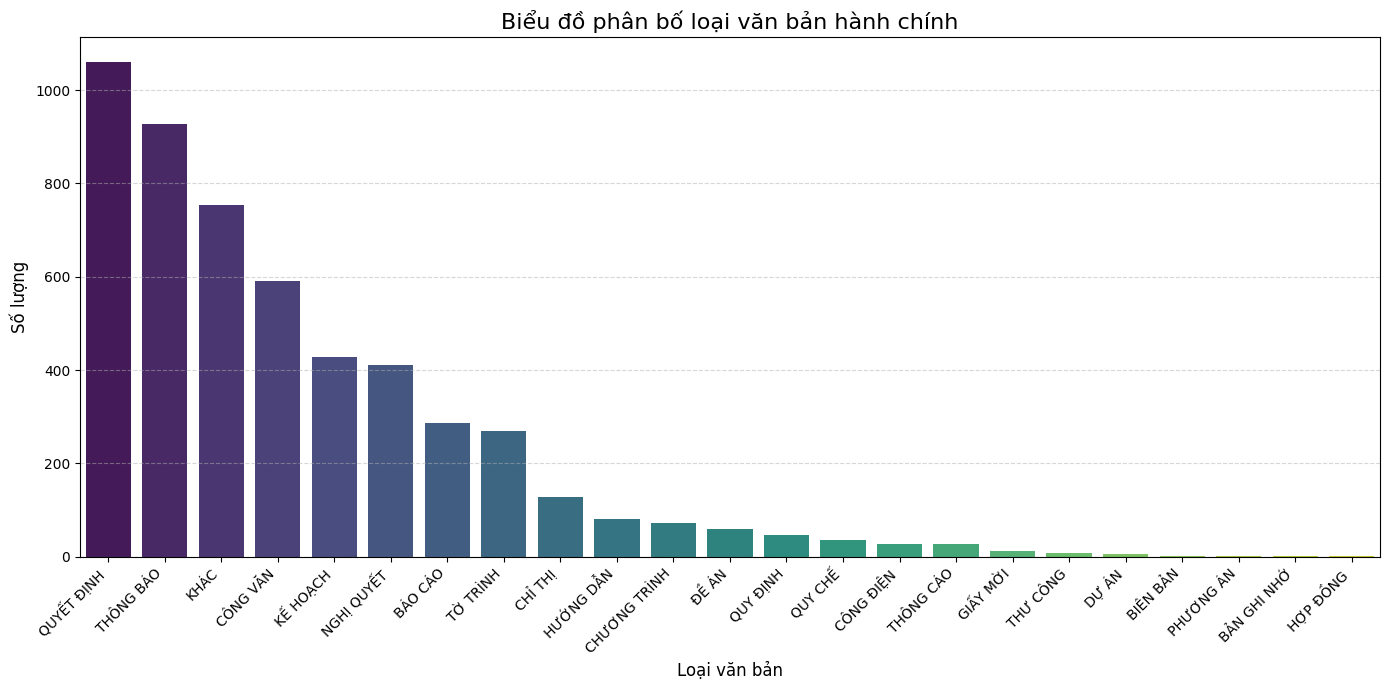

In [26]:
# 📁 5.1.1. Thiết lập đường dẫn file hoàn chỉnh
dataset_folder = Path("/content/drive/MyDrive/DocAIx/data/vanban_dataset")
final_csv_path = dataset_folder / "dataset_final.csv"

# 📥 5.1.2. Đọc dữ liệu từ bản final (không chỉnh sửa)
df = pd.read_csv(final_csv_path, encoding="utf-8-sig")
df["doc_type"] = df["doc_type"].astype(str).str.upper().str.strip()

# 📘 5.1.3. Danh sách 29 loại văn bản hợp lệ
valid_doc_types = {
    "NGHỊ QUYẾT", "QUYẾT ĐỊNH", "CHỈ THỊ", "QUY CHẾ", "QUY ĐỊNH", "THÔNG CÁO",
    "THÔNG BÁO", "HƯỚNG DẪN", "CHƯƠNG TRÌNH", "KẾ HOẠCH", "PHƯƠNG ÁN", "ĐỀ ÁN",
    "DỰ ÁN", "BÁO CÁO", "BIÊN BẢN", "TỜ TRÌNH", "HỢP ĐỒNG", "CÔNG VĂN",
    "CÔNG ĐIỆN", "BẢN GHI NHỚ", "BẢN THỎA THUẬN", "GIẤY ỦY QUYỀN", "GIẤY MỜI",
    "GIẤY GIỚI THIỆU", "GIẤY NGHỈ PHÉP", "PHIẾU GỬI", "PHIẾU CHUYỂN", "PHIẾU BÁO",
    "THƯ CÔNG"
}

# 🧹 5.1.4. Gom nhóm doc_type không nằm trong danh sách → "KHÁC"
df["doc_type_grouped"] = df["doc_type"].apply(
    lambda x: x if x in valid_doc_types else "KHÁC"
)

# 📊 5.1.5. Thống kê phân bố theo nhóm
doc_type_counts = df["doc_type_grouped"].value_counts().sort_values(ascending=False)
plot_df = doc_type_counts.reset_index()
plot_df.columns = ["doc_type", "count"]

# 🎨 5.1.6. Vẽ biểu đồ cột đứng (chuẩn Seaborn ≥ 0.13+, không cảnh báo)
plt.figure(figsize=(14, 7))
sns.barplot(
    data=plot_df,
    x="doc_type",
    y="count",
    hue="doc_type",        # ⚠️ Thêm hue giống x
    palette="viridis",
    legend=False           # 🔕 Không hiện legend
)

plt.title("Biểu đồ phân bố loại văn bản hành chính", fontsize=16)
plt.xlabel("Loại văn bản", fontsize=12)
plt.ylabel("Số lượng", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle="--", alpha=0.5)

plt.show()

## 5.2. Biểu đồ phân bố đơn vị action

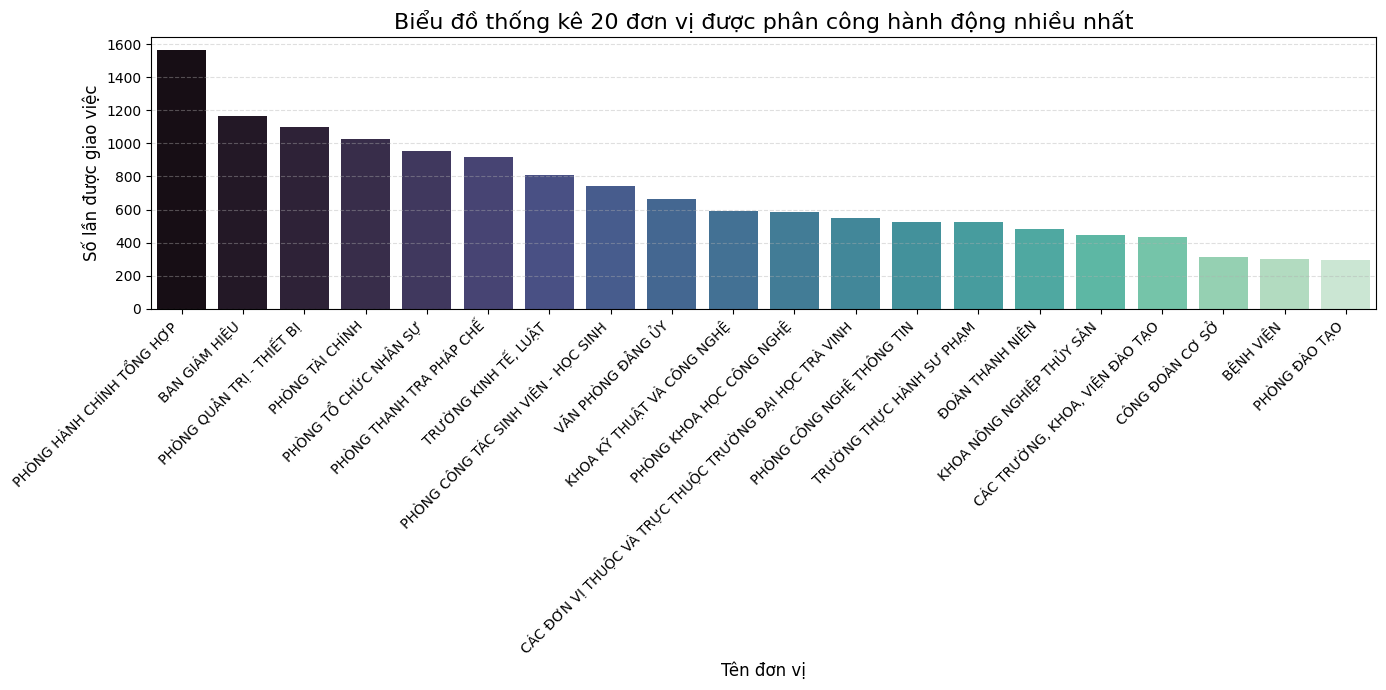

In [28]:
# 📁 5.2.1. Đọc dữ liệu từ bản final
dataset_folder = Path("/content/drive/MyDrive/DocAIx/data/vanban_dataset")
final_csv_path = dataset_folder / "dataset_final.csv"

df = pd.read_csv(final_csv_path, encoding="utf-8-sig")
df["doc_action"] = df["doc_action"].astype(str).str.strip()

# 🧹 5.2.2. Tách đơn vị từ doc_action – bỏ tiền tố "Chuyển"
action_units = []

for val in df["doc_action"]:
    # Bỏ từ "CHUYỂN" hoặc "Chuyển" ở đầu chuỗi (nếu có)
    cleaned = re.sub(r"^CHUYỂN[\s:]+", "", val.strip(), flags=re.IGNORECASE)

    # Tách theo dấu chấm phẩy (;)
    units = [u.strip().upper() for u in cleaned.split(";") if u.strip()]
    action_units.extend(units)

# 📊 5.2.3. Thống kê tần suất từng đơn vị được giao việc
counter = Counter(action_units)
most_common = counter.most_common(20)

labels, counts = zip(*most_common)

# 🎨 5.2.4. Vẽ biểu đồ phân bố Top 20 đơn vị
plt.figure(figsize=(14, 7))
sns.barplot(x=list(labels), y=list(counts), palette="mako", hue=labels, legend=False)

plt.title("Biểu đồ thống kê 20 đơn vị được phân công hành động nhiều nhất", fontsize=16)
plt.xlabel("Tên đơn vị", fontsize=12)
plt.ylabel("Số lần được giao việc", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle="--", alpha=0.4)

plt.show()

## 5.3. Biểu đồ phân bố độ dài văn bản

📊 Thống kê độ dài văn bản (số từ):
count    5235.000000
mean      461.376122
std       124.751815
min        13.000000
25%       385.000000
50%       500.000000
75%       536.000000
90%       572.000000
95%       602.300000
max      2843.000000
Name: doc_length_words, dtype: float64


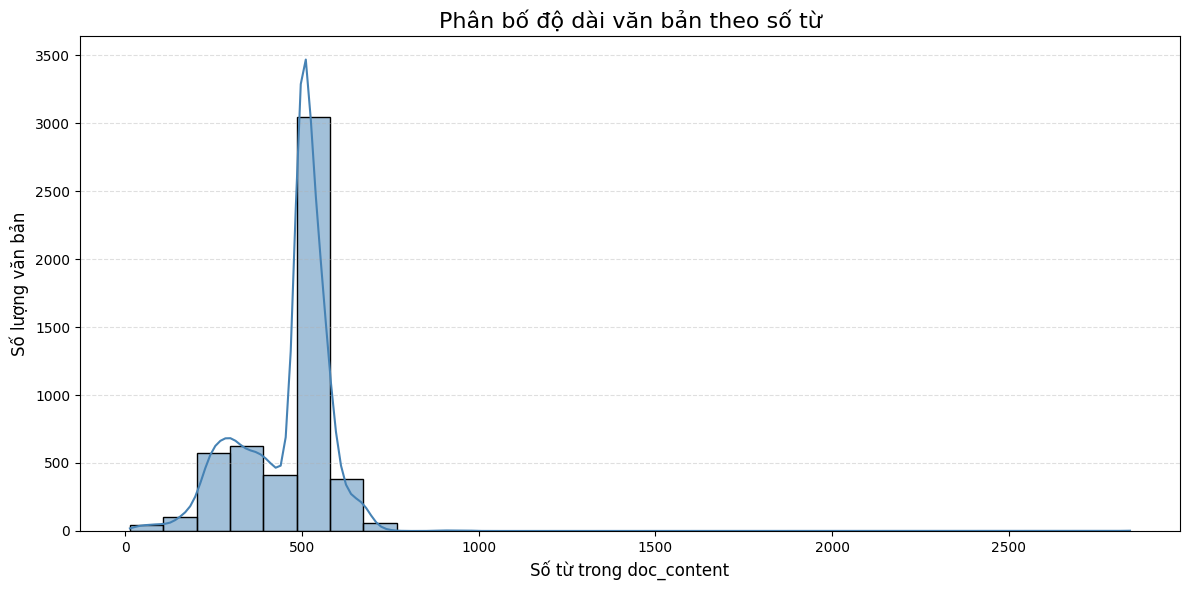

In [32]:
# 📁 5.3.1. Đọc dữ liệu từ file final
dataset_folder = Path("/content/drive/MyDrive/DocAIx/data/vanban_dataset")
final_csv_path = dataset_folder / "dataset_final.csv"

df = pd.read_csv(final_csv_path, encoding="utf-8-sig")
df["doc_content"] = df["doc_content"].astype(str).str.strip()

# 🧮 5.3.2. Tính độ dài văn bản (số từ)
df["doc_length_words"] = df["doc_content"].apply(lambda x: len(x.split()))

# 📊 5.3.3. Thống kê mô tả
desc = df["doc_length_words"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])
print("📊 Thống kê độ dài văn bản (số từ):")
print(desc)

# 🎨 5.3.4. Vẽ biểu đồ histogram phân bố độ dài văn bản
plt.figure(figsize=(12, 6))
sns.histplot(df["doc_length_words"], bins=30, kde=True, color="steelblue")

plt.title("Phân bố độ dài văn bản theo số từ", fontsize=16)
plt.xlabel("Số từ trong doc_content", fontsize=12)
plt.ylabel("Số lượng văn bản", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()